In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functions as f
from tqdm import tqdm

TTN_BIN = 4275
TTN_BINS = [4275, 4276, 4277, 4278]
chrom2_bins = [2490, 4911]

contact_matrix_zero = np.load('/Users/ethan/Desktop/chromatin-heart-dev/samples/contact_matrix_100kb_balanced_zeroed.npy')




# LOAD BIN MAP
bin_map = f.load_bin_map('/Users/ethan/Desktop/chromatin-heart-dev/data/bin_map_human_100000.bed')

gene_bins = []
with open('/Users/ethan/Desktop/chromatin-heart-dev/data/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('/Users/ethan/Desktop/chromatin-heart-dev/data/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]

In [6]:

def build_walk_index(contact_matrix):
    """
    Precompute for each node:
      - neighbors[i]: 1D int array of neighbors
      - cdfs[i]:      1D float array of cumulative probabilities
    """
    N = contact_matrix.shape[0]
    neighbors = [None]*N
    cdfs      = [None]*N

    for i in tqdm(range(N)):
        w = contact_matrix[i]
        idx = np.nonzero(w)[0]
        if idx.size == 0:
            neighbors[i] = np.empty(0, dtype=int)
            cdfs[i]      = np.empty(0, dtype=float)
        else:
            probs = w[idx] / w[idx].sum()
            neighbors[i] = idx
            cdfs[i]      = np.cumsum(probs)
    return neighbors, cdfs

neighbors, cdfs = build_walk_index(contact_matrix_zero) 



100%|██████████| 30894/30894 [00:14<00:00, 2163.84it/s]


In [4]:
contact_matrix = np.load('/Users/ethan/Desktop/chromatin-heart-dev/samples/contact_matrix_100kb_balanced.npy')

## Finding TTN Clique Greedy

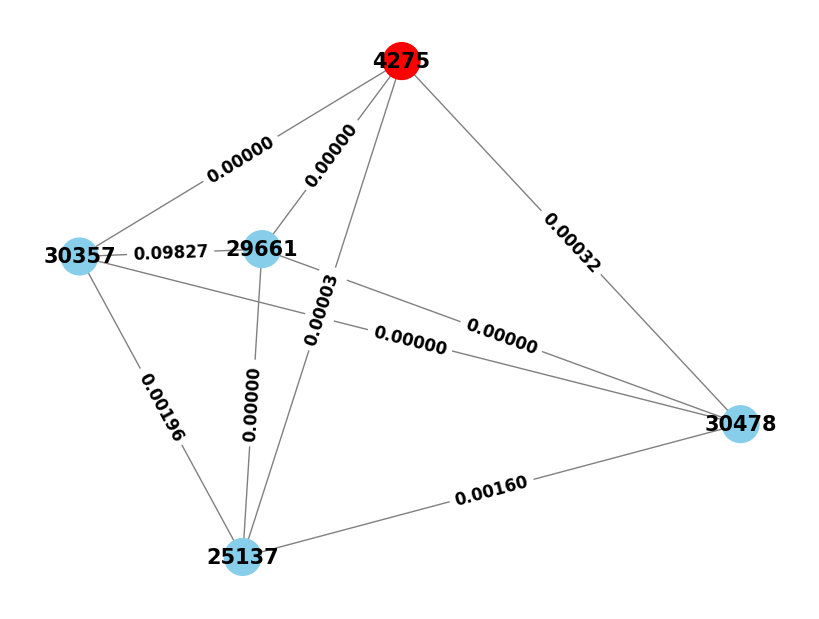

In [15]:
TTN_BIN = 4275
ttn_clique = f.find_clique_greedy(contact_matrix, 5, TTN_BIN, bin_map)
G_TTN = f.clique_to_graph(contact_matrix, ttn_clique, TTN_BIN)
score_greedy = f.calculate_avg_interaction_strength(contact_matrix, ttn_clique)

In [465]:
ttn_clique, score_greedy

([4275, 30478, 25137, 30357, 29661], np.float64(0.010217975885194035))

## Sample Matrix

In [11]:
import numpy as np
from scipy.linalg import eig
import math

def analytical_clique(contact_matrix: np.ndarray, n: int):
    # 1) Build P so that P[i,j] = prob of moving i -> j
    row_sums = contact_matrix.sum(axis=1)
    P = np.zeros_like(contact_matrix, dtype=float)
    for i, s in enumerate(row_sums):
        if s > 0:
            P[i, :] = contact_matrix[i, :] / s
        else:
            # no outgoing edges: stay in place
            P[i, i] = 1.0

    # 2) Compute left eigenvectors of P (i.e., eigenvectors of P^T)
    #    eig returns (w, vl) where vl[:,k] is the left eigenvector for w[k]
    w, vl = eig(P, left=True, right=False)

    # 3) Find the eigenvalue closest to 1
    idx = int(np.argmin(np.abs(w - 1.0)))
    pi = vl[:, idx].real  # take real part

    # 4) Normalize to sum to 1
    pi = pi / np.sum(pi)

    # 5) Pick top-n
    clique = np.argsort(pi)[-n:][::-1]
    return clique, pi

In [9]:
import numpy as np

def analytical_diffusion_clique(contact_matrix: np.ndarray,
                                start_node: int,
                                n: int,
                                alpha: float = 0.1):

    N = contact_matrix.shape[0]

    # 1) Build the row‑stochastic transition matrix P
    P = np.zeros((N, N), dtype=float)
    row_sums = contact_matrix.sum(axis=1)
    for i in range(N):
        if row_sums[i] > 0:
            P[i, :] = contact_matrix[i, :] / row_sums[i]
        else:
            # no neighbors → self‑loop
            P[i, i] = 1.0

    # 2) Form the fundamental matrix: F = (I - (1-alpha)*P)^(-1)
    I = np.eye(N)
    F = np.linalg.inv(I - (1 - alpha) * P)

    # 3) Extract the expected visits for a start at `start_node`
    visits = F[start_node, :]

    # 4) Pick the top‑n nodes by descending visits
    clique = np.argsort(visits)[-n:][::-1]
    return clique, visits

In [92]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from time import time   

# print time taken
def sparse_diffusion_clique(contact_matrix, start_node, n, alpha=0.1, rtol=1e-6):
    # 1) Ensure CSR sparse matrix
    if isinstance(contact_matrix, np.ndarray):
        contact_matrix = sp.csr_matrix(contact_matrix)
    else:
        contact_matrix = contact_matrix.tocsr()

    N = contact_matrix.shape[0]

    # 2) Normalize rows → P
    row_sums = np.array(contact_matrix.sum(axis=1)).ravel()
    P = contact_matrix.tolil()
    inv_row = np.zeros_like(row_sums, dtype=float)
    nonzero = row_sums > 0
    inv_row[nonzero] = 1.0 / row_sums[nonzero]

    for i in range(N):
        if nonzero[i]:
            P.data[i] = [val * inv_row[i] for val in P.data[i]]
        else:
            # self‑loop
            P.rows[i] = [i]
            P.data[i] = [1.0]

    P = P.tocsr()

    # 3) Build M = I - (1-α)P
    M = sp.eye(N, format="csr") - (1 - alpha) * P

    # 4) Setup RHS e_s
    e_s = np.zeros(N, float)
    e_s[start_node] = 1.0

    # 5) Solve (I - (1-α)P)^T v^T = e_s^T via GMRES
    visits, info = spla.gmres(M.T, e_s, rtol=rtol)
    if info != 0:
        raise RuntimeError(f"GMRES did not converge (info={info})")

    # 6) Top‑n
    clique = np.argsort(visits)[-n:][::-1]

    return clique

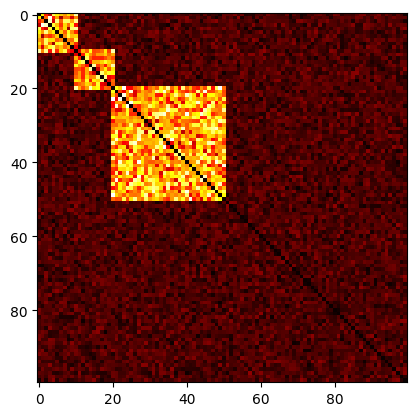

In [95]:
# create a sample matrix
sample_matrix = f.generate_sample_matrix_bins(100)

# visualize the contact matrix hic 
plt.imshow(sample_matrix, cmap='hot', interpolation='nearest')
plt.show()


In [99]:
analytical_diffusion_clique(sample_matrix, start_node=4, n=6)

(array([ 4, 10, 20, 46, 27, 31]),
 array([0.13642218, 0.10830499, 0.11377428, 0.13673938, 1.0928636 ,
        0.13370933, 0.11624781, 0.1313767 , 0.09891088, 0.13606299,
        0.16482125, 0.09230105, 0.08114673, 0.08956826, 0.08759814,
        0.08205844, 0.07942827, 0.08279898, 0.08795037, 0.08070437,
        0.15898327, 0.13036214, 0.12650819, 0.13243099, 0.12627897,
        0.13274435, 0.11817584, 0.13826351, 0.13261843, 0.12288448,
        0.12415005, 0.13699836, 0.13346056, 0.12458798, 0.13191175,
        0.13254263, 0.11774792, 0.13575828, 0.1222014 , 0.1284033 ,
        0.12718152, 0.12859007, 0.12045191, 0.13161288, 0.13583494,
        0.136336  , 0.14076072, 0.13130198, 0.13541571, 0.13161314,
        0.13021202, 0.06026107, 0.06005018, 0.06327714, 0.05587525,
        0.05614313, 0.05083917, 0.06085742, 0.0561014 , 0.0564111 ,
        0.05328453, 0.0550345 , 0.05888943, 0.05707946, 0.06021835,
        0.05489686, 0.05700932, 0.0585354 , 0.05515983, 0.05747252,
        0.0525

In [101]:
f.random_walk(sample_matrix, start_node=4, n=6, num_molecules=100000, alpha=0.1, verbose=True)  

100%|██████████| 100000/100000 [00:08<00:00, 11493.31it/s]


(array([ 4, 10, 20, 46, 31,  0]),
 array([ 13678,  10711,  11351,  13372, 109345,  13325,  11629,  13082,
          9823,  13671,  16515,   9265,   8099,   9099,   8654,   8152,
          7865,   8285,   8767,   8034,  15799,  12961,  12541,  13286,
         12674,  13170,  11799,  13510,  13322,  12116,  12538,  13784,
         13174,  12170,  13166,  13187,  11768,  13443,  12120,  12822,
         12561,  12784,  11988,  12999,  13506,  13528,  13933,  13213,
         13475,  12879,  13035,   6144,   5989,   6382,   5531,   5592,
          5172,   6102,   5636,   5622,   5336,   5411,   5854,   5727,
          6024,   5500,   5742,   5870,   5396,   5787,   5189,   6205,
          5461,   5608,   5455,   6247,   5441,   5290,   5711,   5166,
          5582,   5889,   5743,   5589,   5774,   6405,   5371,   5318,
          6024,   6442,   5633,   5988,   6040,   5759,   5348,   5651,
          5822,   5209,   6235,   6141]))

In [89]:
sparse_diffusion_clique(sample_matrix, start_node=4, n=6, alpha=0.1, rtol=1e-6)

Time taken: 18.9736 seconds


array([   4, 2000, 1000,  995,  122,  369])

In [93]:
import time
import numpy as np
import pandas as pd


sizes = [100, 1000, 5000, 10000]
results = []

for N in sizes:
    # 1) generate
    mat = f.generate_sample_matrix_bins(N)
    
    row = {'N': N}
    
    # 2) analytical
    t0 = time.perf_counter()
    analytical_diffusion_clique(mat, start_node=4, n=6)
    row['analytical_s'] = time.perf_counter() - t0
    
    # 3) random walk
    t0 = time.perf_counter()
    f.random_walk(mat, start_node=4, n=6, num_molecules=10000, alpha=0.1, verbose=False)
    row['random_walk_s'] = time.perf_counter() - t0
    
    # 4) sparse
    t0 = time.perf_counter()
    sparse_diffusion_clique(mat, start_node=4, n=6, alpha=0.1, rtol=1e-6)
    row['sparse_s'] = time.perf_counter() - t0
    
    results.append(row)

# 5) summarize
df = pd.DataFrame(results).set_index('N')
print(df)

       analytical_s  random_walk_s   sparse_s
N                                            
100        0.000733       0.877489   0.002346
1000       0.020807       1.498228   0.129506
5000       2.168417       3.933550   3.510755
10000     18.353374       6.983316  18.530091


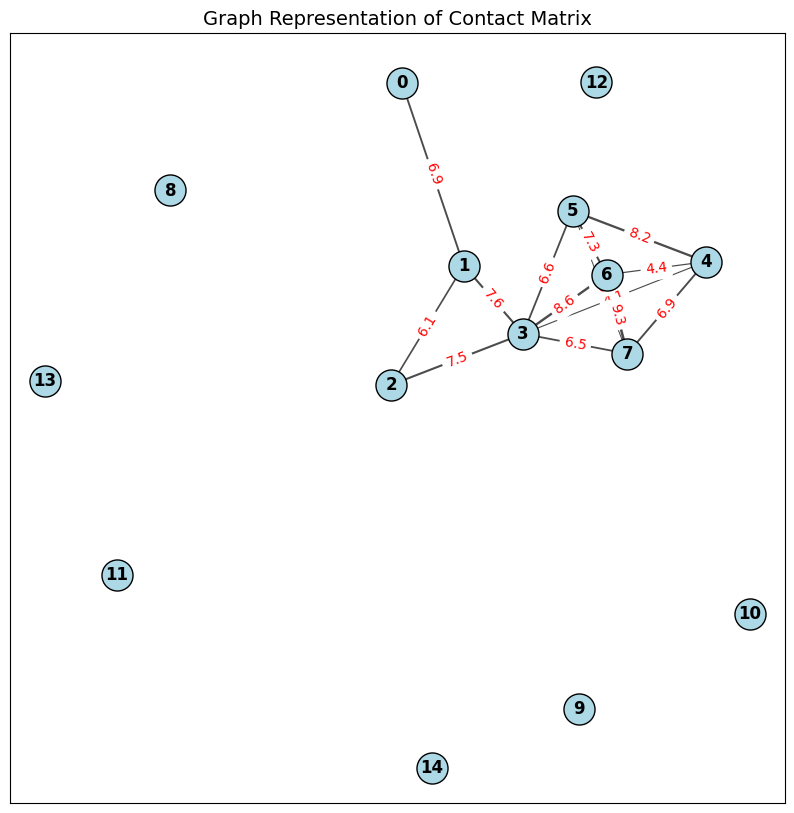

In [ ]:


# zero out cm if not above 2
sample_matrix = np.where(contact_matrix < 2, 0, sample_matrix)

# plot this on a graph
G = f.construct_graph_from_contact_matrix(sample_matrix, threshold=0)



## Random Walk Clique Size 5

In [399]:
top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=1000, alpha=0.05, verbose=True) 
rw_score_5  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
rw_score_5  


100%|██████████| 1000/1000 [00:03<00:00, 290.04it/s]


np.float64(0.0003882285340160518)

Processing: 100%|██████████| 100/100 [04:52<00:00,  2.92s/iteration]


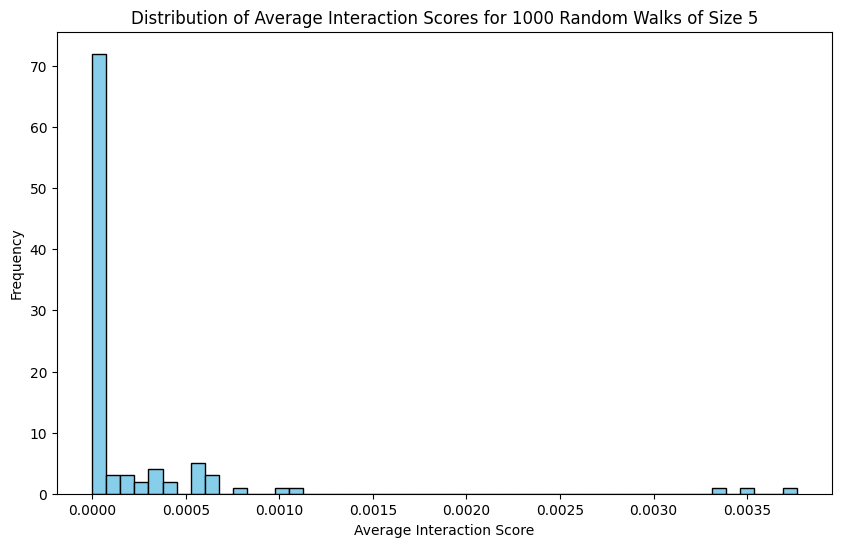

In [393]:
bg_model_random_walk_5 = f.create_background_model_rw(contact_matrix_zero, 5, num_molecules=1000, num_iterations=100, alpha=0.05)

In [402]:
f.simple_p_test(rw_score_5, bg_model_random_walk_5)

np.float64(0.16)

In [400]:
rw_score_5

np.float64(0.0003882285340160518)

## Random Walk Clique Size 5 with 100 molecules

Processing: 100%|██████████| 1000/1000 [04:50<00:00,  3.44iteration/s]


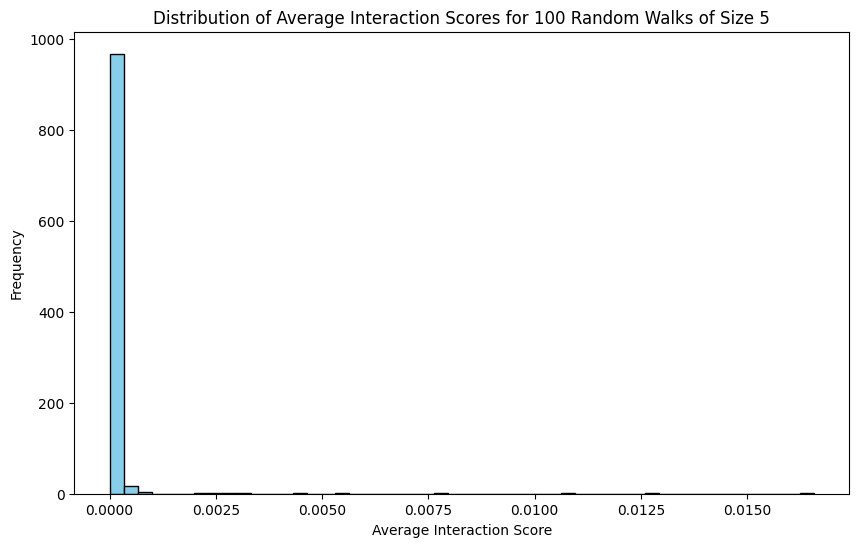

In [409]:
bg_model_random_walk_sample = f.create_background_model_rw(contact_matrix_zero, 5, num_molecules=100, num_iterations=1000, alpha=0.05)

In [418]:
top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=100, alpha=0.05, verbose=True) 
rw_score_5  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
rw_score_5  


100%|██████████| 100/100 [00:00<00:00, 297.81it/s]


np.float64(0.0003770925531242224)

In [420]:
f.simple_p_test(rw_score_5, bg_model_random_walk_sample)

np.float64(0.031)

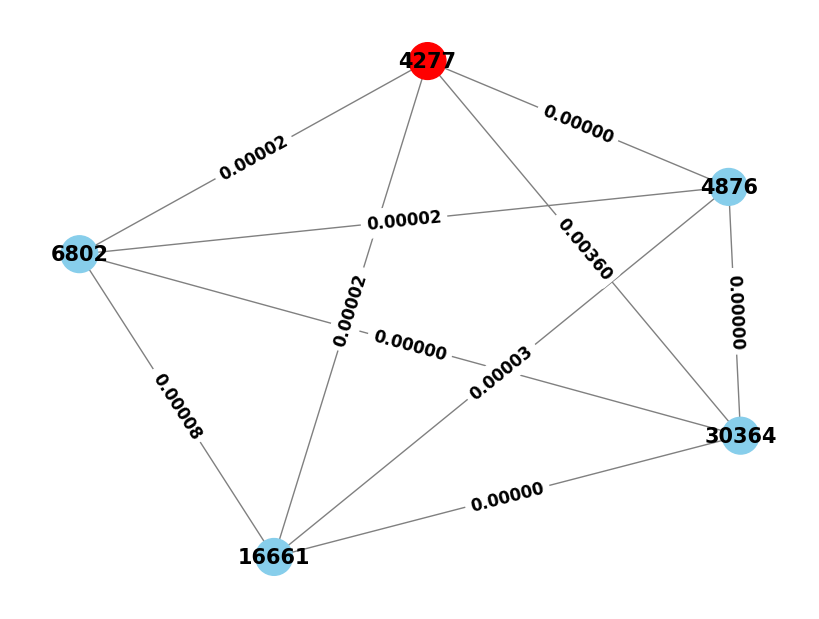

In [430]:
nodes = [ 4277, 30364, 16661,  6802,  4876]
f.clique_to_graph(contact_matrix_zero, nodes, TTN_BIN)   


## Random Walk Clique Size 10

In [ ]:
top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 10, num_molecules=1000, alpha=0.05, verbose=True) 
rw_score_10  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)

100%|██████████| 1000/1000 [00:03<00:00, 286.90it/s]


Processing: 100%|██████████| 100/100 [04:38<00:00,  2.79s/iteration]


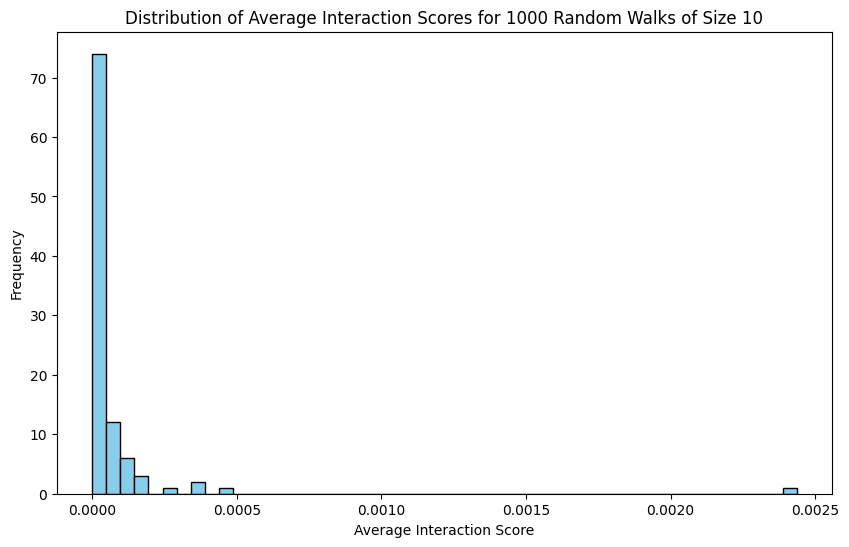

In [388]:
bg_model_random_walk_10 = f.create_background_model_rw(contact_matrix_zero, 10, num_molecules=1000, num_iterations=100, alpha=0.05)
# save list of scores in /background_models

with open('/Users/ethan/Desktop/chromatin-heart-dev/background_models/rw_scores_10.txt', 'w') as f:
    for item in bg_model_random_walk_10:
        f.write("%s\n" % item)

In [557]:
f.simple_p_test(rw_score_10, bg_model_random_walk_10)

np.float64(0.31)

In [392]:
rw_score_10

np.float64(4.0472059410651015e-05)

## RW Clique Size 15

Processing: 100%|██████████| 1000/1000 [50:01<00:00,  3.00s/iteration]


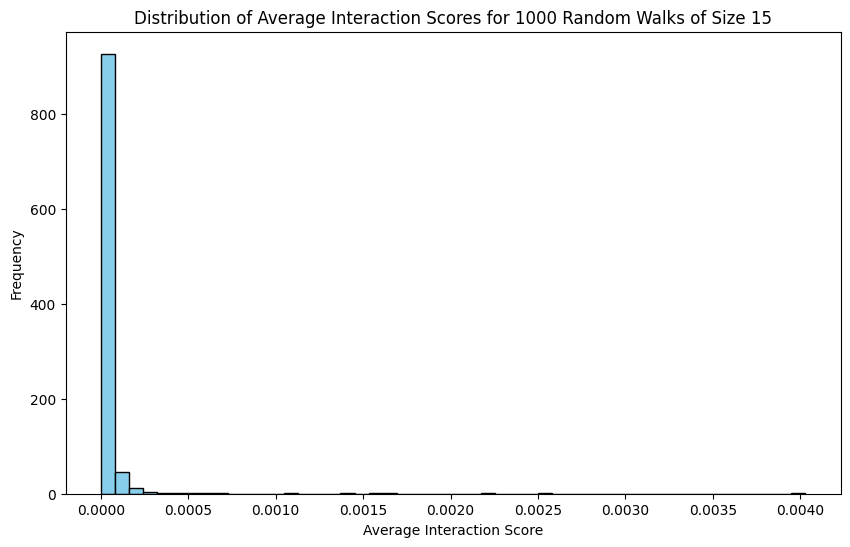

In [490]:
bg_model_random_walk_15 = f.create_background_model_rw(contact_matrix_zero, 15, num_molecules=1000, num_iterations=1000, alpha=0.05)

In [496]:
top_nodes_rw_15 = f.random_walk(contact_matrix_zero, TTN_BIN, 15, num_molecules=1000, alpha=0.05, verbose=True) 
rw_score_15  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
print(top_nodes_rw_15)
print(rw_score_15)

100%|██████████| 1000/1000 [00:03<00:00, 297.18it/s]

[ 4275 27734 24275 24937 20669 16879 11312 25597 27958 11448 17531 26857
 21873 28048 20209]
0.0003770925531242224


In [497]:
import functions as f
f.simple_p_test(rw_score_15, bg_model_random_walk_15)

np.float64(0.013)

## Plot of Clique Size to P Value

In [7]:
from scipy import stats

def t_test(observed_score, score_list):
    t_stat, p_value = stats.ttest_1samp(score_list, observed_score)
    return p_value


def mann_whitney_u_test(ttn_score, random_scores):
    ttn_array = np.array([ttn_score] * len(random_scores)) 
    u_statistic, p_value = stats.mannwhitneyu(ttn_array, random_scores, alternative='greater')
    return p_value

def empirical_p_value(observed_score, random_scores):
    count = sum(score >= observed_score for score in random_scores)
    p_value = count / len(random_scores)
    return p_value

    """
    Compares an observed score to a list of scores using a permutation test.
    """
    combined_scores = np.concatenate([score_list, [observed_score]])
    n_observed = 1
    n_other = len(score_list)

    observed_statistic = observed_score # Or another relevant statistic

    extreme_count = 0
    for _ in range(n_permutations):
        permuted_indices = np.random.permutation(len(combined_scores))
        permuted_observed_score = combined_scores[permuted_indices[-1]] # Assume observed score is the last one

        permuted_statistic = permuted_observed_score # Use the same statistic

        # Adjust the comparison based on the direction of significance you're looking for
        # For "more significant" (assuming higher score), check if permuted statistic is as extreme or more extreme
        if permuted_statistic >= observed_statistic:
            extreme_count += 1

    p_value = extreme_count / n_permutations
    return p_value


In [539]:
TTN_BIN

4275

Processing: 100%|██████████| 1000/1000 [01:49<00:00,  9.17iteration/s]


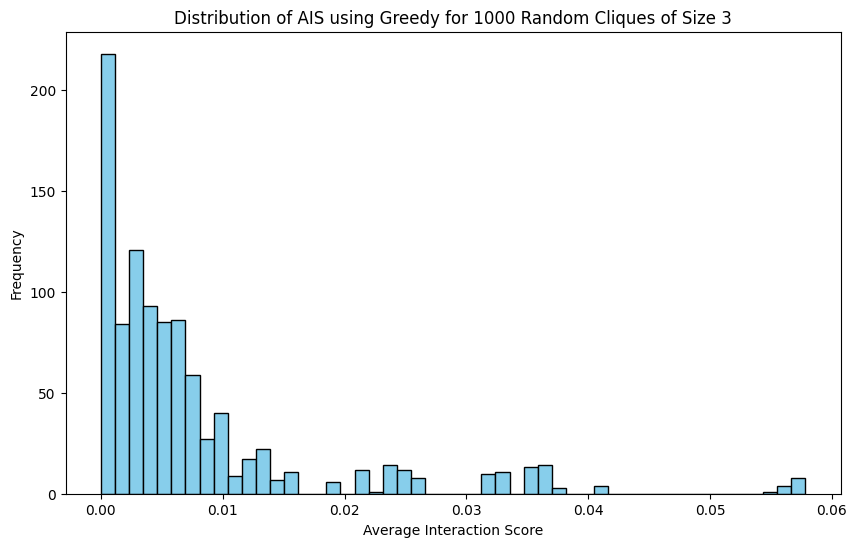

Processing: 100%|██████████| 1000/1000 [02:54<00:00,  5.74iteration/s]


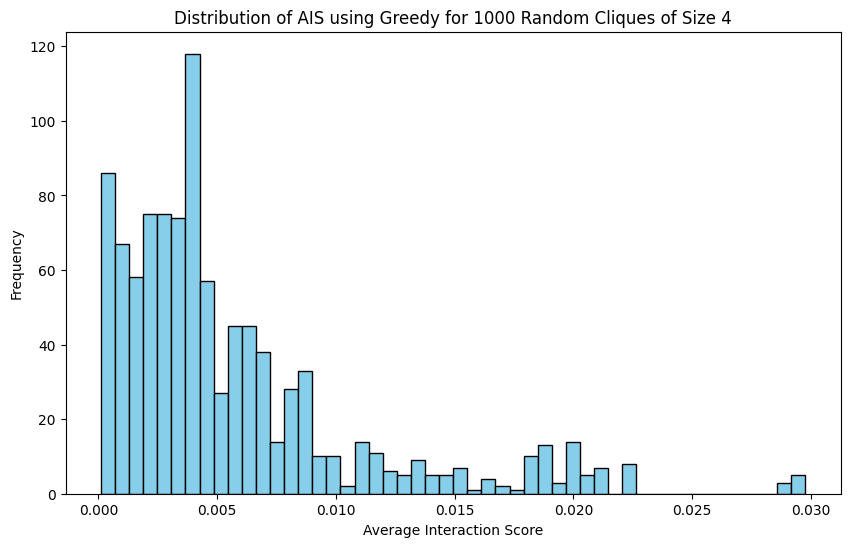

Processing: 100%|██████████| 1000/1000 [04:41<00:00,  3.56iteration/s]


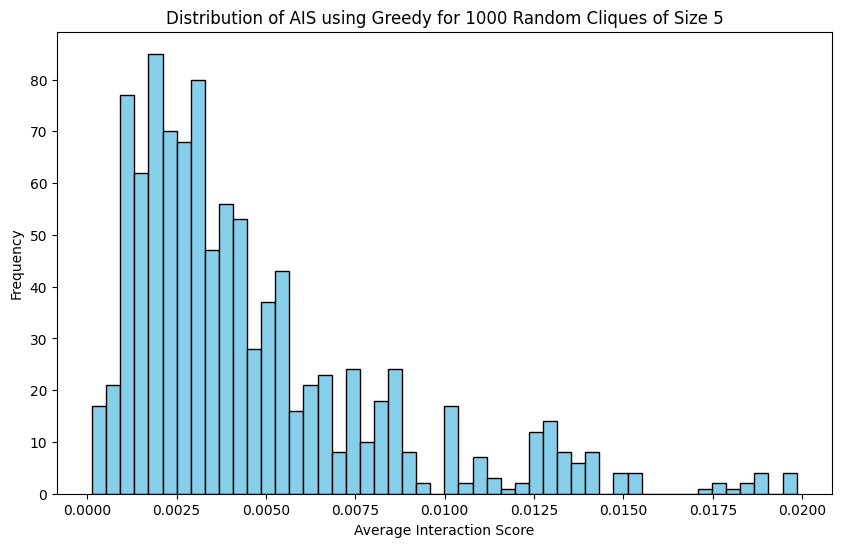

Processing: 100%|██████████| 1000/1000 [09:11<00:00,  1.81iteration/s]


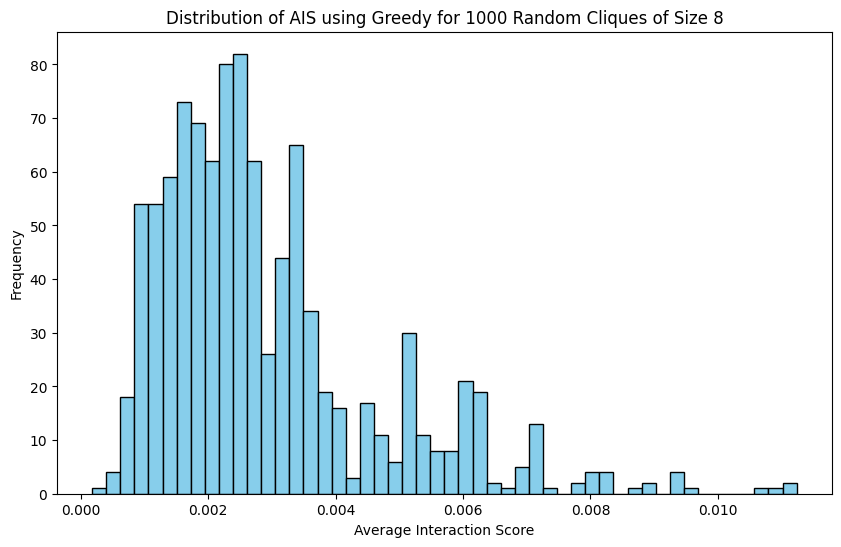

Processing: 100%|██████████| 1000/1000 [13:28<00:00,  1.24iteration/s]


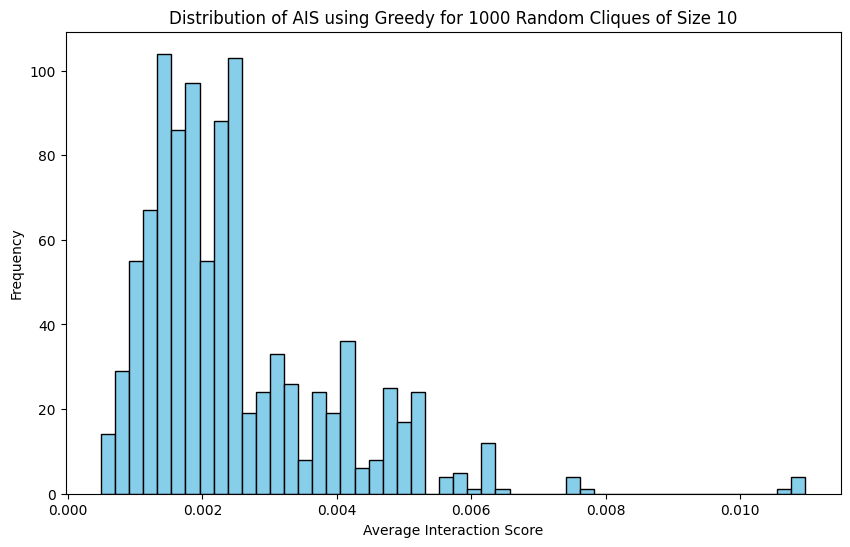

Processing: 100%|██████████| 1000/1000 [20:59<00:00,  1.26s/iteration]


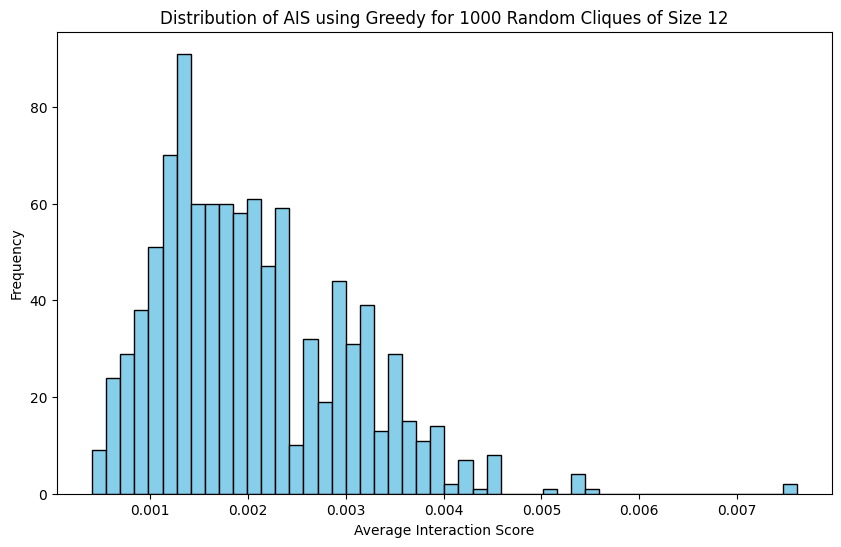

Processing: 100%|██████████| 1000/1000 [24:56<00:00,  1.50s/iteration]


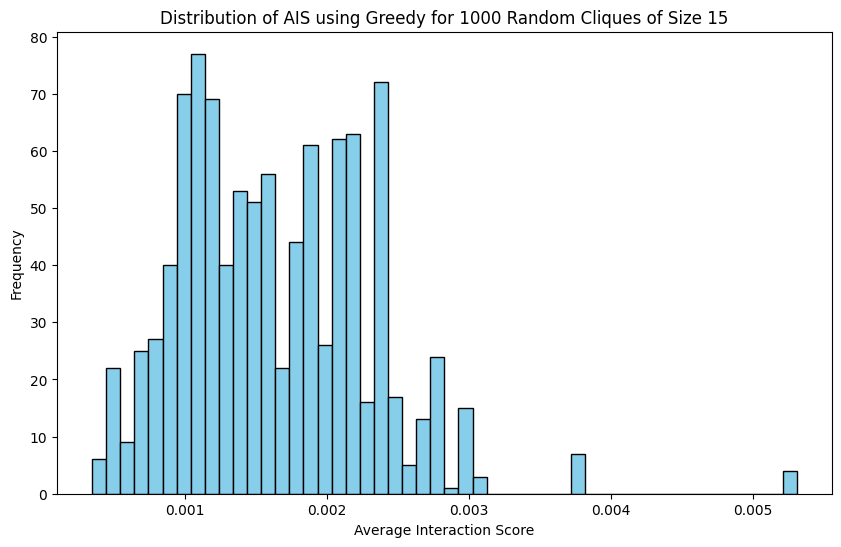

Processing: 100%|██████████| 1000/1000 [33:59<00:00,  2.04s/iteration]


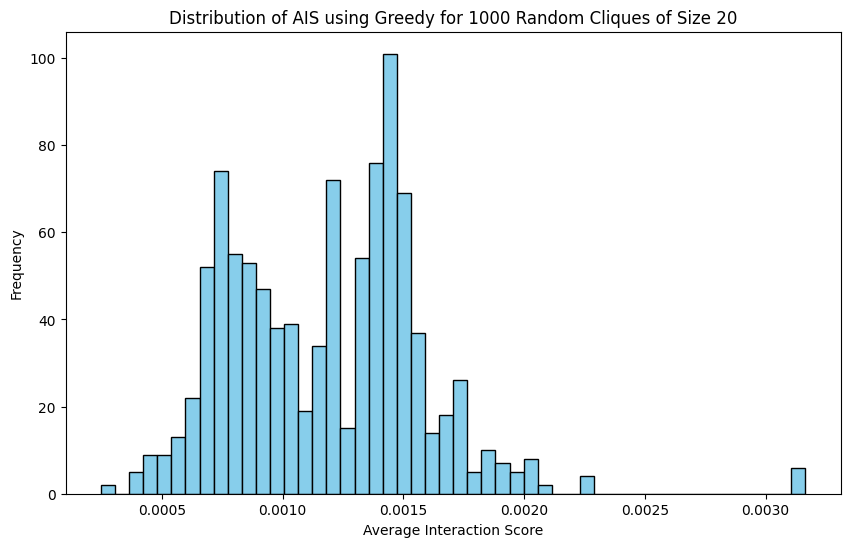

Processing: 100%|██████████| 1000/1000 [3:03:40<00:00, 11.02s/iteration] 


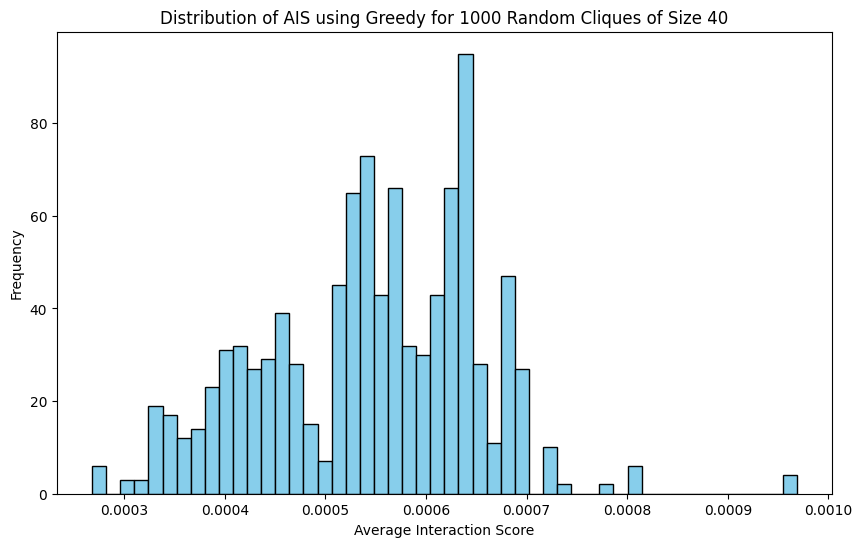

Processing:  26%|██▌       | 256/1000 [2:36:56<7:36:08, 36.79s/iteration] 


KeyboardInterrupt: 

In [51]:
from tqdm import tqdm

clique_sizes = [3, 4, 5, 8, 10, 12, 15, 20, 40, 60]
p_values = []

for i in clique_sizes:
    top_nodes = f.find_clique_greedy(contact_matrix_zero, i, TTN_BIN, bin_map)
    greedy_score = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
    bg_model_greedy = f.create_background_model_greedy_strong(contact_matrix_zero, i, bin_map, gene_bins=gene_bins, num_iterations=1000)
    
    p_value = mann_whitney_u_test(greedy_score, bg_model_greedy) 
    p_values.append(p_value)

plt.plot(clique_sizes, p_values, marker='o')
plt.xlabel('Clique Size')
plt.ylabel('p-value')
plt.yscale('log')  # Useful if values vary widely
plt.axhline(0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.legend()
plt.show()

## Distribution Plot of Backgrounds

In [22]:
TTN_BIN

4275

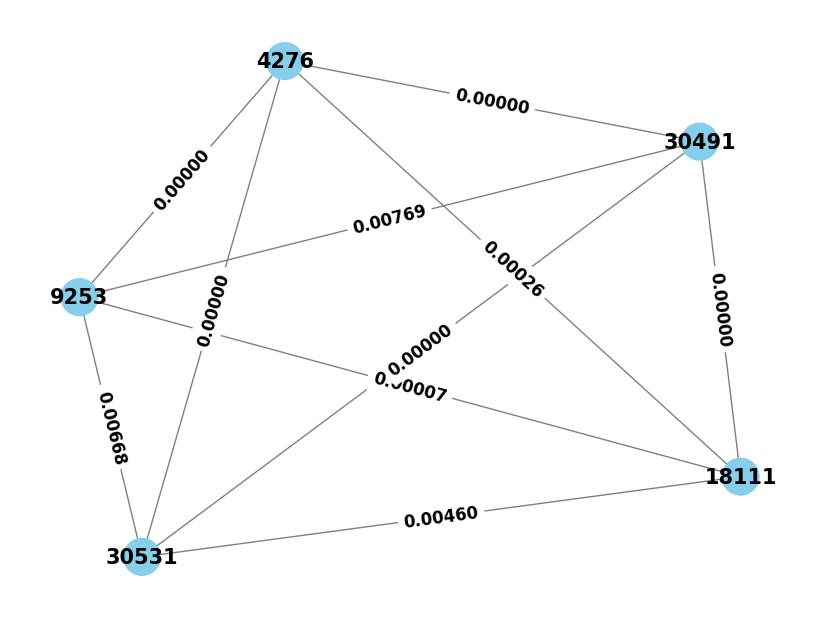

In [26]:
test = f.find_clique_greedy(contact_matrix_zero, 5, 4276, bin_map)
f.clique_to_graph(contact_matrix_zero, test, TTN_BIN)

In [25]:
f.calculate_avg_interaction_strength(contact_matrix_zero, test)

np.float64(0.010217975885194035)

Processing: 100%|██████████| 1000/1000 [04:24<00:00,  3.78iteration/s]


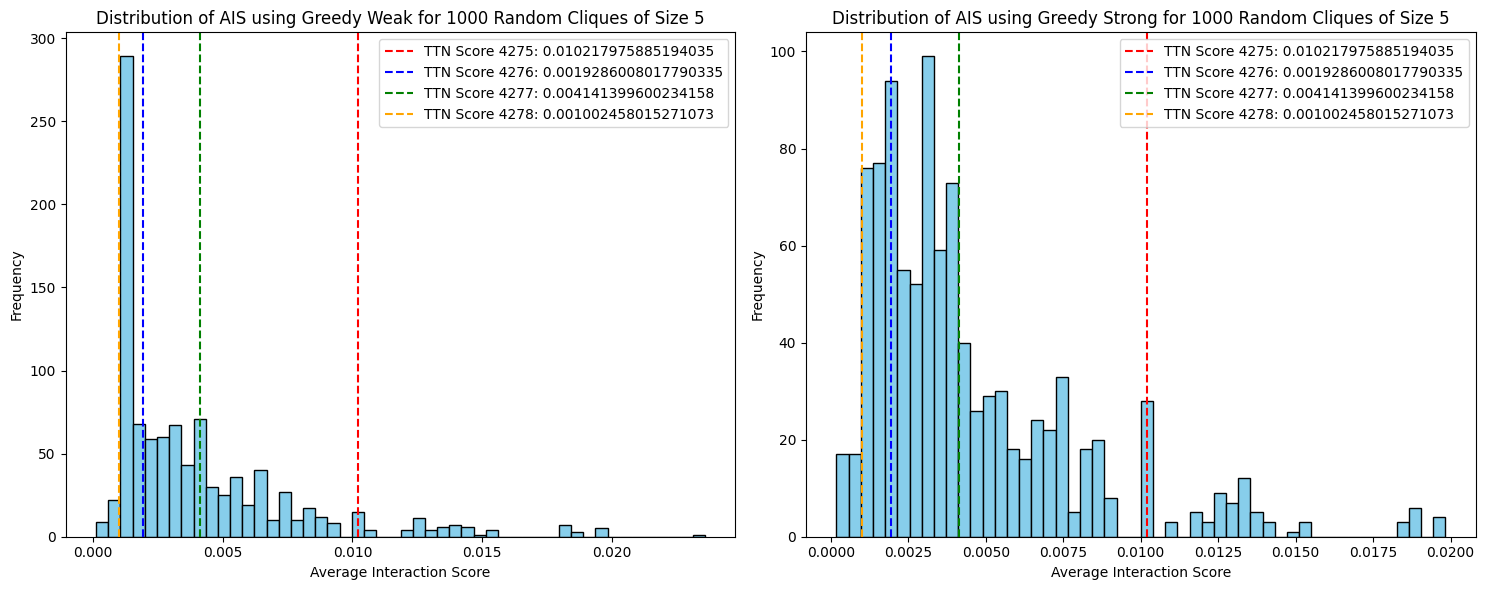

Processing: 100%|██████████| 1000/1000 [16:52<00:00,  1.01s/iteration]


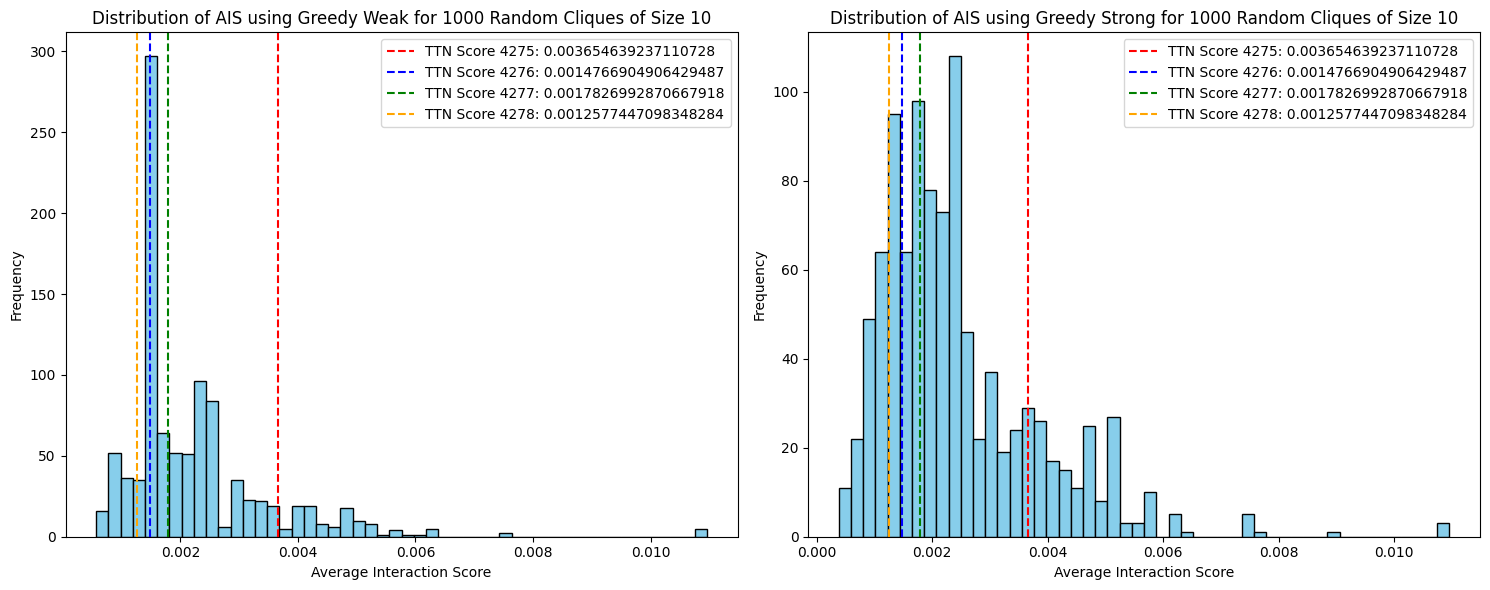

KeyboardInterrupt: 

In [114]:
from tqdm import tqdm
import matplotlib.pyplot as plt

clique_sizes = [5, 10, 20, 40]
p_values = []
num_iterations = 1000
ttn_bins = [4275, 4276, 4277, 4278]
colors = ['red', 'blue', 'green', 'orange']  # Define different colors for each bin

for i in clique_sizes:
    ttn_cliques = [f.find_clique_greedy(contact_matrix_zero, i, ttn_bin, bin_map) for ttn_bin in ttn_bins]
    ttn_scores = [f.calculate_avg_interaction_strength(contact_matrix_zero, ttn_clique) for ttn_clique in ttn_cliques]
    
    bg_model_greedy_weak = f.create_background_model_greedy(contact_matrix_zero, i, bin_map, non_gene_bins, label='weak', num_iterations=num_iterations, display=False)
    bg_model_greedy_strong = f.create_background_model_greedy(contact_matrix_zero, i, bin_map, gene_bins, label='strong', num_iterations=num_iterations, display=False)

    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot weak model
    axes[0].hist(bg_model_greedy_weak, bins=50, color='skyblue', edgecolor='black')
    for idx, (ttn_score, ttn_bin) in enumerate(zip(ttn_scores, ttn_bins)):
        axes[0].axvline(x=ttn_score, color=colors[idx], linestyle='--', label=f'TTN Score {ttn_bin}: {ttn_score}')
    axes[0].set_xlabel('Average Interaction Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Distribution of AIS using Greedy Weak for {num_iterations} Weak Cliques of Size {i}')
    axes[0].legend()

    # Plot strong model
    axes[1].hist(bg_model_greedy_strong, bins=50, color='skyblue', edgecolor='black')
    for idx, (ttn_score, ttn_bin) in enumerate(zip(ttn_scores, ttn_bins)):
        axes[1].axvline(x=ttn_score, color=colors[idx], linestyle='--', label=f'TTN Score {ttn_bin}: {ttn_score}')
    axes[1].set_xlabel('Average Interaction Score')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Distribution of AIS using Greedy for {num_iterations} Strong Cliques of Size {i}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Processing: 100%|██████████| 1000/1000 [1:47:02<00:00,  6.42s/iteration] 


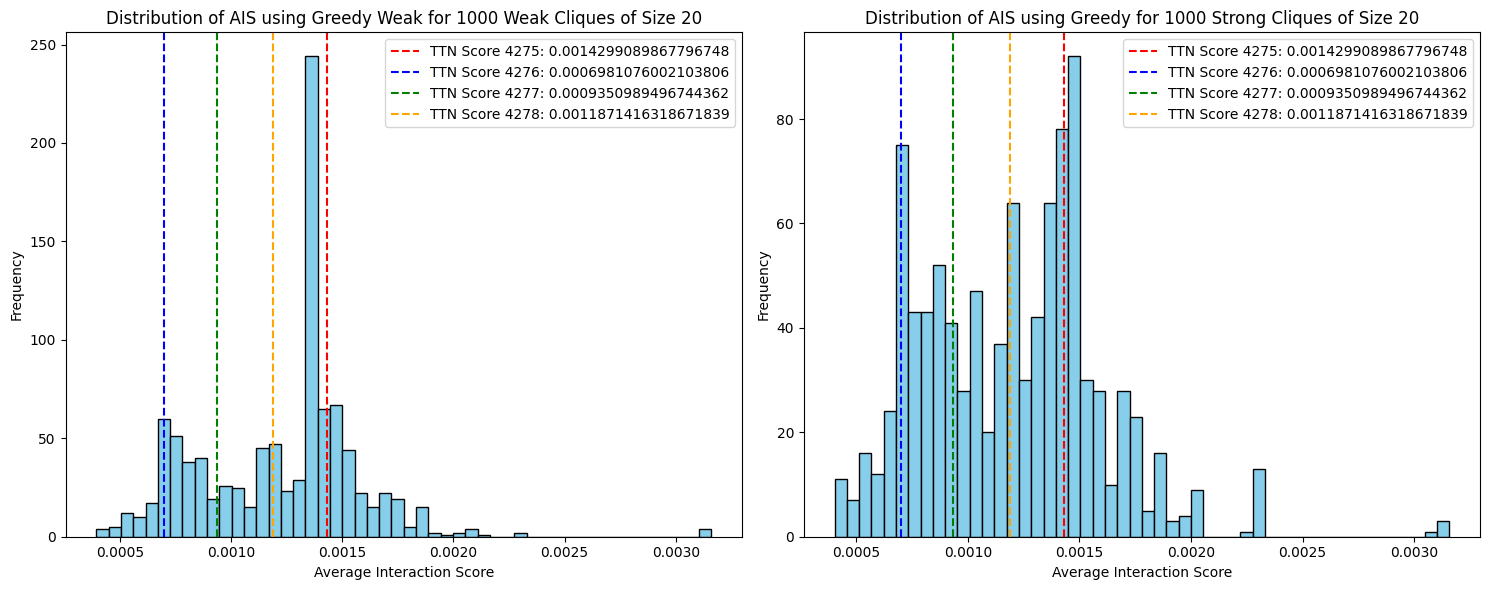

Processing:   1%|          | 7/1000 [02:54<6:52:47, 24.94s/iteration]


KeyboardInterrupt: 

In [115]:
from tqdm import tqdm
import matplotlib.pyplot as plt

clique_sizes = [20]
p_values = []
num_iterations = 1000
ttn_bins = [4275, 4276, 4277, 4278]
colors = ['red', 'blue', 'green', 'orange']  # Define different colors for each bin

for i in clique_sizes:
    ttn_cliques = [f.find_clique_greedy(contact_matrix_zero, i, ttn_bin, bin_map) for ttn_bin in ttn_bins]
    ttn_scores = [f.calculate_avg_interaction_strength(contact_matrix_zero, ttn_clique) for ttn_clique in ttn_cliques]
    
    bg_model_greedy_weak = f.create_background_model_greedy(contact_matrix_zero, i, bin_map, non_gene_bins, label='weak', num_iterations=num_iterations, display=False)
    bg_model_greedy_strong = f.create_background_model_greedy(contact_matrix_zero, i, bin_map, gene_bins, label='strong', num_iterations=num_iterations, display=False)
    
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot weak model
    axes[0].hist(bg_model_greedy_weak, bins=50, color='skyblue', edgecolor='black')
    for idx, (ttn_score, ttn_bin) in enumerate(zip(ttn_scores, ttn_bins)):
        axes[0].axvline(x=ttn_score, color=colors[idx], linestyle='--', label=f'TTN Score {ttn_bin}: {ttn_score}')
    axes[0].set_xlabel('Average Interaction Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Distribution of AIS using Greedy Weak for {num_iterations} Weak Cliques of Size {i}')
    axes[0].legend()

    # Plot strong model
    axes[1].hist(bg_model_greedy_strong, bins=50, color='skyblue', edgecolor='black')
    for idx, (ttn_score, ttn_bin) in enumerate(zip(ttn_scores, ttn_bins)):
        axes[1].axvline(x=ttn_score, color=colors[idx], linestyle='--', label=f'TTN Score {ttn_bin}: {ttn_score}')
    axes[1].set_xlabel('Average Interaction Score')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Distribution of AIS using Greedy for {num_iterations} Strong Cliques of Size {i}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Sampling cliques: 100%|██████████| 500/500 [00:22<00:00, 22.11iter/s]


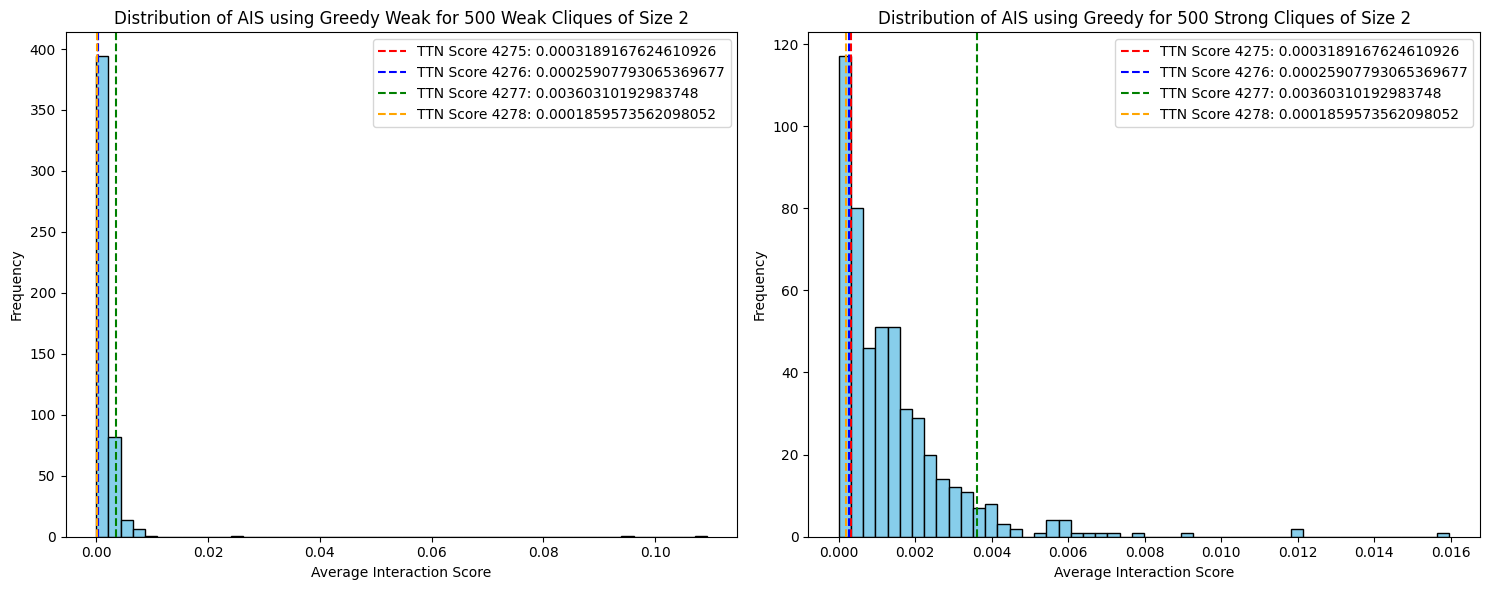

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt

clique_sizes = [2]
p_values = []
num_iterations = 500
ttn_bins = [4275, 4276, 4277, 4278]
colors = ['red', 'blue', 'green', 'orange']  # Define different colors for each bin

for i in clique_sizes:
    ttn_cliques = [f.find_clique_greedy(contact_matrix_zero, i, ttn_bin, bin_map) for ttn_bin in ttn_bins]
    ttn_scores = [f.calculate_avg_interaction_strength(contact_matrix_zero, ttn_clique) for ttn_clique in ttn_cliques]
    
    bg_model_greedy_weak = f.create_background_model_greedy(contact_matrix_zero, i, bin_map, non_gene_bins, label='weak', num_iterations=num_iterations, display=False)
    bg_model_greedy_strong = f.create_background_model_greedy(contact_matrix_zero, i, bin_map, gene_bins, label='strong', num_iterations=num_iterations, display=False)

    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot weak model
    axes[0].hist(bg_model_greedy_weak, bins=50, color='skyblue', edgecolor='black')
    for idx, (ttn_score, ttn_bin) in enumerate(zip(ttn_scores, ttn_bins)):
        axes[0].axvline(x=ttn_score, color=colors[idx], linestyle='--', label=f'TTN Score {ttn_bin}: {ttn_score}')
    axes[0].set_xlabel('Average Interaction Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Distribution of AIS using Greedy Weak for {num_iterations} Weak Cliques of Size {i}')
    axes[0].legend()

    # Plot strong model
    axes[1].hist(bg_model_greedy_strong, bins=50, color='skyblue', edgecolor='black')
    for idx, (ttn_score, ttn_bin) in enumerate(zip(ttn_scores, ttn_bins)):
        axes[1].axvline(x=ttn_score, color=colors[idx], linestyle='--', label=f'TTN Score {ttn_bin}: {ttn_score}')
    axes[1].set_xlabel('Average Interaction Score')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Distribution of AIS using Greedy for {num_iterations} Strong Cliques of Size {i}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## Violin Plots

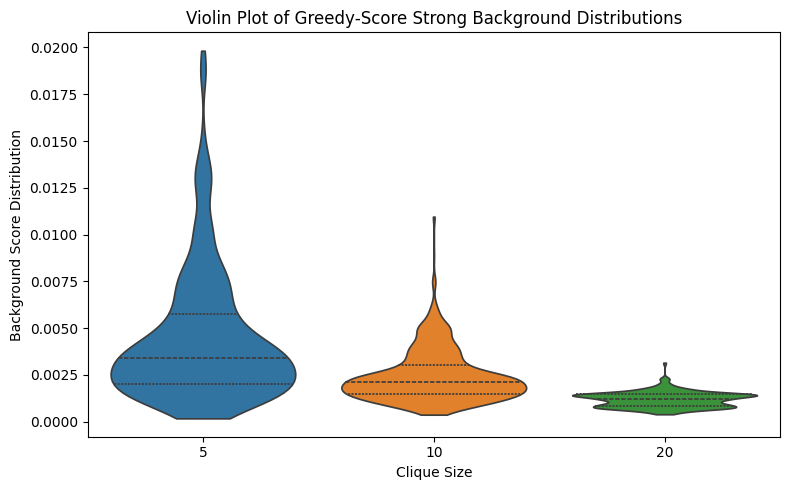

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

clique_sizes = [5, 10, 20]

bg_scores_list = []
for size in clique_sizes:
    path = f'/Users/ethan/Desktop/chromatin-heart-dev/background_models/greedy_scores_{size}_iterations_1000_strong.txt'
    with open(path, 'r') as file:
        scores = [float(line) for line in file]
    bg_scores_list.append(scores)

# Create the violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=bg_scores_list, inner="quartile", cut=0)
plt.xticks(ticks=range(len(clique_sizes)), labels=clique_sizes)
plt.xlabel('Clique Size')
plt.ylabel('Background Score Distribution')
plt.title('Violin Plot of Greedy‐Score Strong Background Distributions')
plt.tight_layout()
plt.show()

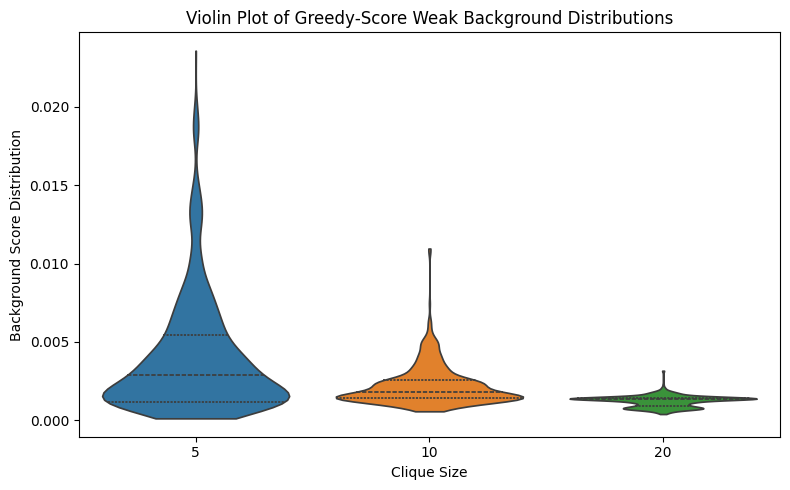

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

clique_sizes = [5, 10, 20]

bg_scores_list = []
for size in clique_sizes:
    path = f'/Users/ethan/Desktop/chromatin-heart-dev/background_models/greedy_scores_{size}_iterations_1000_weak.txt'
    with open(path, 'r') as f:
        scores = [float(line) for line in f]
    bg_scores_list.append(scores)

# Create the violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=bg_scores_list, inner="quartile", cut=0)
plt.xticks(ticks=range(len(clique_sizes)), labels=clique_sizes)
plt.xlabel('Clique Size')
plt.ylabel('Background Score Distribution')
plt.title('Violin Plot of Greedy‐Score Weak Background Distributions')
plt.tight_layout()
plt.show()

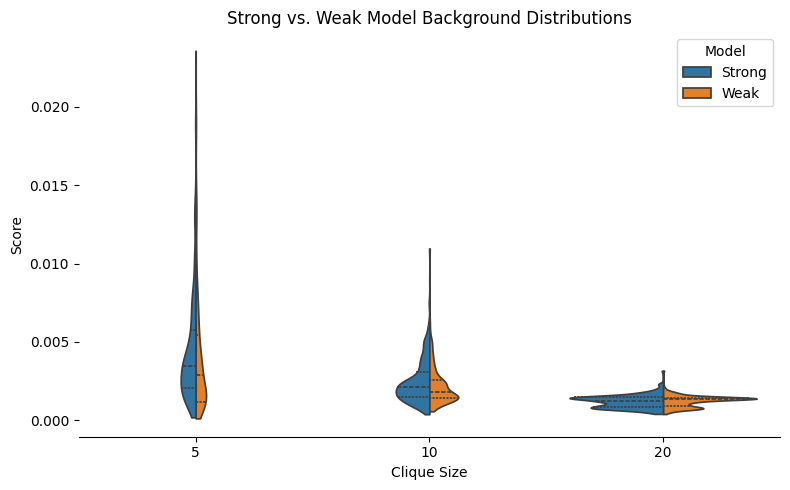

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

clique_sizes = [5, 10, 20]
records = []

for model_type in ["strong", "weak"]:
    for size in clique_sizes:
        path = (f"/Users/ethan/Desktop/chromatin-heart-dev/"
                f"background_models/greedy_scores_{size}_iterations_1000_{model_type}.txt")
        with open(path, "r") as f:
            scores = [float(line) for line in f]
        for s in scores:
            records.append({
                "Clique Size": size,
                "Score": s,
                "Model": "Strong" if model_type == "strong" else "Weak"
            })

df = pd.DataFrame.from_records(records)

# 2) Plot a split‐violin
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df,
    x="Clique Size",
    y="Score",
    hue="Model",
    split=True,            # split each violin in half
    inner="quartile",      # show median + quartiles
    cut=0                  # don’t extend past data
)
sns.despine(left=True)
plt.title("Strong vs. Weak Model Background Distributions")
plt.tight_layout()
plt.show()

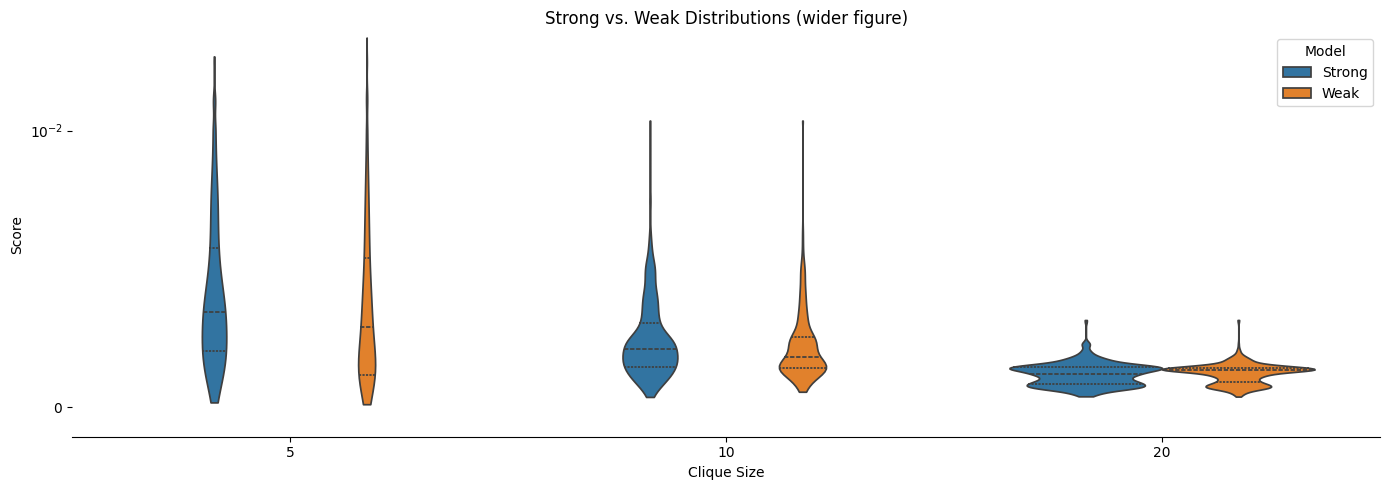

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


clique_sizes = [5, 10, 20]
records = []
for model_type in ["strong", "weak"]:
    for size in clique_sizes:
        path = (
            f"/Users/ethan/Desktop/chromatin-heart-dev/"
            f"background_models/greedy_scores_{size}_iterations_1000_{model_type}.txt"
        )
        with open(path, "r") as f:
            scores = [float(line) for line in f]
        for s in scores:
            records.append({
                "Clique Size": size,
                "Score": s,
                "Model": "Strong" if model_type=="strong" else "Weak"
            })



df = pd.DataFrame.from_records(records)

# ——— Plot with extra width ———
plt.figure(figsize=(14, 5))    # make it wider!
ax = sns.violinplot(
    data=df,
    x="Clique Size",
    y="Score",
    hue="Model",
    dodge=True,
    width=0.7,                # controls how “fat” each violin is
    inner="quartile",
    cut=0
)
sns.despine(left=True)
ax.set_yscale('symlog', linthresh=0.01)
plt.title("Strong vs. Weak Distributions (wider figure)")
plt.tight_layout()
plt.show()

## 5 Violin Plot

In [ ]:
# LOAD BIN MAP
bin_map_loc = f.load_bin_map_loc('/Users/ethan/Desktop/chromatin-heart-dev/data/bin_map_human_100000.bed')

In [107]:
import os

def get_top_n_tf_clique(clique_size):
    # Load the transcription factor binding sites
    data_dir = './data/transcription_factors'
    tf_files = os.listdir(data_dir)
    interaction_scores = []

    # Contains top 1 bin for each TF
    max_bins = []
    bin_set = set()

    # Return counts of transcription factor binding sites in each 100kb bin
    def process_bed_file(file_path):
        bin_counts = {}

        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('#') or not line.strip():
                    continue
                columns = line.split()
                
                chrom = columns[0]
                start_position = int(columns[1])    
                
                bin_number = f.find_bin(chrom, start_position, bin_map_loc)
                
                if bin_number not in bin_counts:
                    bin_counts[bin_number] = 0
                bin_counts[bin_number] += 1

        return bin_counts



    for filename in os.listdir(data_dir):
        # open file

        try:    
            bin_counts = process_bed_file(os.path.join(data_dir, filename))
        except:
            print(f'Error processing {filename}')
            continue

        # get top 20 bins
        top_bins = sorted(bin_counts, key=bin_counts.get, reverse=True)[:clique_size]

        # print the top bins and corresponding counts
        print(f'Transcription factor: {filename}')
        print(f'Top {clique_size} bins: {top_bins}')
        print(f'Counts: {[bin_counts[bin] for bin in top_bins]}')

        max_bins.append(top_bins[0])
        bin_set.update(top_bins)

        interaction_strength = f.calculate_avg_interaction_strength(contact_matrix_zero, top_bins)
        interaction_scores.append(interaction_strength)

    return interaction_scores
    

In [110]:
import os

def get_middle_n_tf_clique(clique_size):
    # Load the transcription factor binding sites
    data_dir = './data/transcription_factors'
    tf_files = os.listdir(data_dir)
    interaction_scores = []

    # Contains middle bins for each TF
    middle_bins = []
    bin_set = set()

    # Return counts of transcription factor binding sites in each 100kb bin
    def process_bed_file(file_path):
        bin_counts = {}

        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('#') or not line.strip():
                    continue
                columns = line.split()
                
                chrom = columns[0]
                start_position = int(columns[1])    
                
                bin_number = f.find_bin(chrom, start_position, bin_map_loc)
                
                if bin_number not in bin_counts:
                    bin_counts[bin_number] = 0
                bin_counts[bin_number] += 1

        return bin_counts

    for filename in os.listdir(data_dir):
        try:    
            bin_counts = process_bed_file(os.path.join(data_dir, filename))
        except:
            print(f'Error processing {filename}')
            continue

 
        sorted_bins = sorted(bin_counts.items(), key=lambda x: x[1], reverse=True)

        total_bins = len(sorted_bins)
        
        start_index = (total_bins - clique_size) // 2
        if start_index < 0:  
            start_index = 0
        
        middle_n_bins = [bin_num for bin_num, _ in sorted_bins[start_index:start_index + clique_size]]

        # print middle n bins and corresponding counts
        print(f'Transcription factor: {filename}')
        print(f'Middle {clique_size} bins: {middle_n_bins}')
        print(f'Counts: {[bin_counts[bin] for bin in middle_n_bins]}')
        
        
        if len(middle_n_bins) < clique_size:
            middle_n_bins = [bin_num for bin_num, _ in sorted_bins]
        
        if middle_n_bins: 
            middle_bins.append(middle_n_bins[0])
            bin_set.update(middle_n_bins)

            interaction_strength = f.calculate_avg_interaction_strength(contact_matrix_zero, middle_n_bins)
            interaction_scores.append(interaction_strength)

    return interaction_scores

In [90]:
import functions as f

# do greedy on the top bins of each transcription factor
def bg_greedy_top_bin_tf(contact_matrix_zero, max_bins, clique_size, bin_map):
    interaction_scores = []
    for bin in tqdm(max_bins):
        top_nodes = f.find_clique_greedy(contact_matrix_zero, clique_size, bin, bin_map)
        greedy_score  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
        interaction_scores.append(greedy_score)

    return interaction_scores

In [111]:
test1 = get_middle_n_tf_clique(2)

Transcription factor: ENCFF146SYU.bed
Middle 2 bins: [27769, 9787]
Counts: [2, 2]
Transcription factor: ENCFF134BQO.bed
Middle 2 bins: [677, 2884]
Counts: [1, 1]
Transcription factor: ENCFF157HQD.bed
Middle 2 bins: [1512, 28208]
Counts: [1, 1]
Transcription factor: ENCFF185BRL.bed
Middle 2 bins: [28482, 25308]
Counts: [2, 2]
Transcription factor: ENCFF485GWN.bed
Middle 2 bins: [22421, 25311]
Counts: [2, 2]
Transcription factor: ENCFF882AEU.bed
Middle 2 bins: [21242, 26888]
Counts: [1, 1]
Transcription factor: ENCFF828NYA.bed
Middle 2 bins: [25393, 18272]
Counts: [1, 1]
Transcription factor: ENCFF639KLW.bed
Middle 2 bins: [1842, 20128]
Counts: [1, 1]
Transcription factor: ENCFF099PYR.bed
Middle 2 bins: [30078, 8279]
Counts: [2, 2]
Transcription factor: ENCFF878FBM.bed
Middle 2 bins: [24698, 389]
Counts: [1, 1]
Transcription factor: ENCFF785MSW.bed
Middle 2 bins: [473, 26656]
Counts: [1, 1]
Transcription factor: ENCFF488IGF.bed
Middle 2 bins: [23335, 25405]
Counts: [1, 1]
Transcription f

In [108]:
test2 = get_top_n_tf_clique(2)

Transcription factor: ENCFF146SYU.bed
Top 2 bins: [10572, 19511]
Counts: [30, 28]
Transcription factor: ENCFF134BQO.bed
Top 2 bins: [4799, 2350]
Counts: [8, 8]
Transcription factor: ENCFF157HQD.bed
Top 2 bins: [19237, 10892]
Counts: [25, 17]
Transcription factor: ENCFF185BRL.bed
Top 2 bins: [28038, 10617]
Counts: [28, 26]
Transcription factor: ENCFF485GWN.bed
Top 2 bins: [28038, 1606]
Counts: [34, 28]
Transcription factor: ENCFF882AEU.bed
Top 2 bins: [1552, 24986]
Counts: [6, 6]
Transcription factor: ENCFF828NYA.bed
Top 2 bins: [10879, 24995]
Counts: [15, 12]
Transcription factor: ENCFF639KLW.bed
Top 2 bins: [18745, 18746]
Counts: [5, 5]
Transcription factor: ENCFF099PYR.bed
Top 2 bins: [1925, 22125]
Counts: [28, 24]
Transcription factor: ENCFF878FBM.bed
Top 2 bins: [27040, 27045]
Counts: [13, 13]
Transcription factor: ENCFF785MSW.bed
Top 2 bins: [10874, 10892]
Counts: [9, 8]
Transcription factor: ENCFF488IGF.bed
Top 2 bins: [19237, 26616]
Counts: [8, 7]
Transcription factor: ENCFF535W

In [112]:
np.mean(test1), np.mean(test2)

(np.float64(2.594777594341058e-05), np.float64(4.18925108849575e-05))

100%|██████████| 138/138 [09:32<00:00,  4.15s/it]


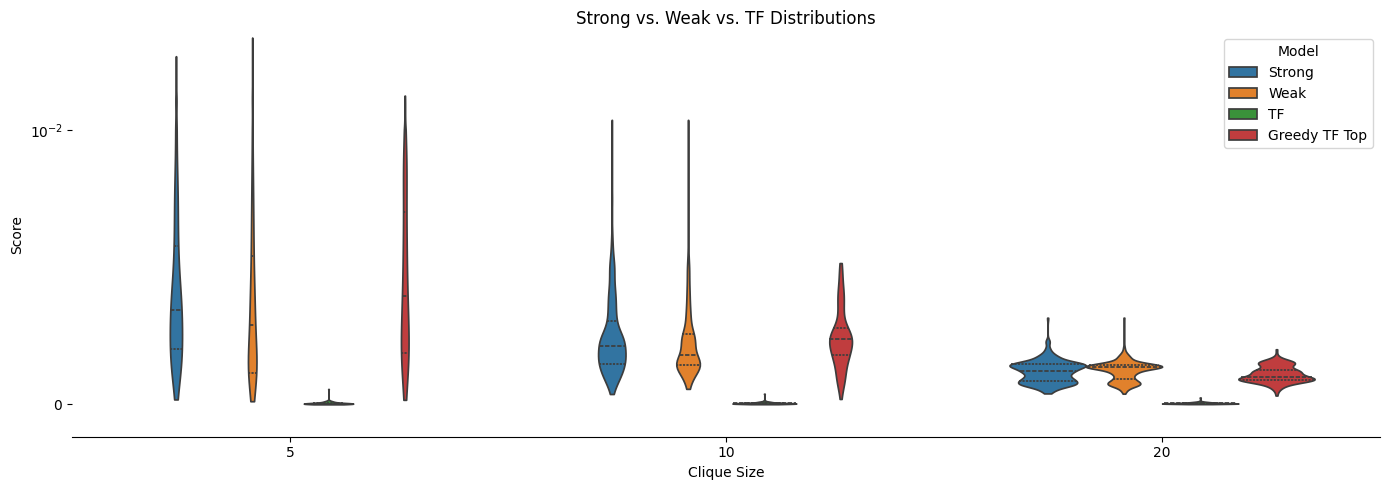

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import functions as f

def get_top_n_tf_clique(clique_size):
    # Load the transcription factor binding sites
    data_dir = './data/transcription_factors'
    tf_files = os.listdir(data_dir)
    interaction_scores = []

    # Contains top 1 bin for each TF
    max_bins = []
    bin_set = set()

    # Return counts of transcription factor binding sites in each 100kb bin
    def process_bed_file(file_path):
        bin_counts = {}

        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('#') or not line.strip():
                    continue
                columns = line.split()
                
                chrom = columns[0]
                start_position = int(columns[1])    
                
                bin_number = f.find_bin(chrom, start_position, bin_map_loc)
                
                if bin_number not in bin_counts:
                    bin_counts[bin_number] = 0
                bin_counts[bin_number] += 1

        return bin_counts



    for filename in os.listdir(data_dir):
        # open file

        try:    
            bin_counts = process_bed_file(os.path.join(data_dir, filename))
        except:
            print(f'Error processing {filename}')
            continue

        # get top 20 bins
        top_bins = sorted(bin_counts, key=bin_counts.get, reverse=True)[:clique_size]

        max_bins.append(top_bins[0])
        bin_set.update(top_bins)

        interaction_strength = f.calculate_avg_interaction_strength(contact_matrix_zero, top_bins)
        interaction_scores.append(interaction_strength)

    return interaction_scores
    
# do greedy on the top bins of each transcription factor
def bg_greedy_top_bin_tf(contact_matrix_zero, max_bins, clique_size, bin_map):
    interaction_scores = []
    for bin in tqdm(max_bins):
        top_nodes = f.find_clique_greedy(contact_matrix_zero, clique_size, bin, bin_map)
        greedy_score  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
        interaction_scores.append(greedy_score)

    return interaction_scores



# ——— parameters & record collection ———
clique_sizes = [5, 10, 20]
records = []

# 1) load your precomputed “strong”/“weak” scores from disk
for model_type in ["strong", "weak"]:
    label = "Strong" if model_type == "strong" else "Weak"
    for size in clique_sizes:
        path = (
            f"/Users/ethan/Desktop/chromatin-heart-dev/"
            f"background_models/greedy_scores_{size}_iterations_1000_{model_type}.txt"
        )
        with open(path, "r") as fh:
            scores = [float(line) for line in fh]
        for s in scores:
            records.append({
                "Clique Size": size,
                "Score": s,
                "Model": label
            })

# 2) now call your TF‐function for each clique size and append those too
for size in clique_sizes:
    tf_scores = get_top_n_tf_clique(size)
    for s in tf_scores:
        records.append({
            "Clique Size": size,
            "Score": s,
            "Model": "TF"
        })

# 3) call bg_greedy_top_bin_tf for each clique size and append those too
for size in clique_sizes:
    bg_scores = bg_greedy_top_bin_tf(contact_matrix_zero, max_bins, size, bin_map)
    for s in bg_scores:
        records.append({
            "Clique Size": size,
            "Score": s,
            "Model": "Greedy TF Top"
        })

# build the DataFrame
df = pd.DataFrame.from_records(records)

# ——— plot ———
plt.figure(figsize=(14, 5))
ax = sns.violinplot(
    data=df,
    x="Clique Size",
    y="Score",
    hue="Model",      # will now show Strong, Weak, TF
    dodge=True,
    width=0.7,
    inner="quartile",
    cut=0
)
sns.despine(left=True)
ax.set_yscale('symlog', linthresh=0.01)
ax.set_title("Strong vs. Weak vs. TF Distributions")
plt.tight_layout()
plt.show()

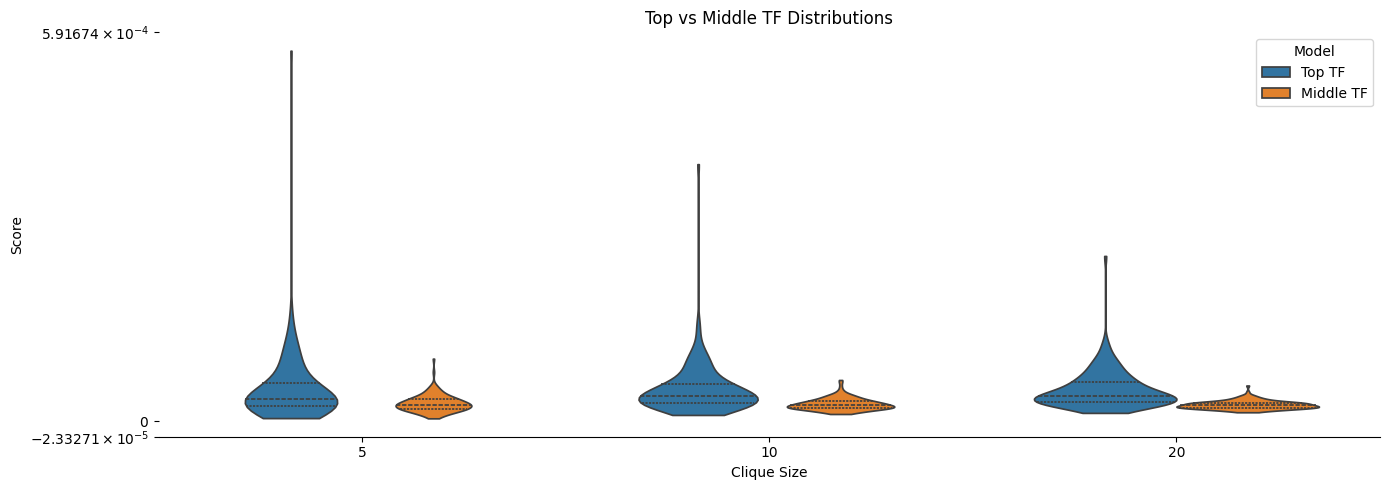

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import functions as f

def get_top_n_tf_clique(clique_size):
    # Load the transcription factor binding sites
    data_dir = './data/transcription_factors'
    tf_files = os.listdir(data_dir)
    interaction_scores = []

    # Contains top 1 bin for each TF
    max_bins = []
    bin_set = set()

    # Return counts of transcription factor binding sites in each 100kb bin
    def process_bed_file(file_path):
        bin_counts = {}

        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('#') or not line.strip():
                    continue
                columns = line.split()
                
                chrom = columns[0]
                start_position = int(columns[1])    
                
                bin_number = f.find_bin(chrom, start_position, bin_map_loc)
                
                if bin_number not in bin_counts:
                    bin_counts[bin_number] = 0
                bin_counts[bin_number] += 1

        return bin_counts



    for filename in os.listdir(data_dir):
        # open file

        try:    
            bin_counts = process_bed_file(os.path.join(data_dir, filename))
        except:
            print(f'Error processing {filename}')
            continue

        # get top 20 bins
        top_bins = sorted(bin_counts, key=bin_counts.get, reverse=True)[:clique_size]

        max_bins.append(top_bins[0])
        bin_set.update(top_bins)

        interaction_strength = f.calculate_avg_interaction_strength(contact_matrix_zero, top_bins)
        interaction_scores.append(interaction_strength)

    return interaction_scores

def get_middle_n_tf_clique(clique_size):
    # Load the transcription factor binding sites
    data_dir = './data/transcription_factors'
    tf_files = os.listdir(data_dir)
    interaction_scores = []

    # Contains middle bins for each TF
    middle_bins = []
    bin_set = set()

    # Return counts of transcription factor binding sites in each 100kb bin
    def process_bed_file(file_path):
        bin_counts = {}

        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('#') or not line.strip():
                    continue
                columns = line.split()
                
                chrom = columns[0]
                start_position = int(columns[1])    
                
                bin_number = f.find_bin(chrom, start_position, bin_map_loc)
                
                if bin_number not in bin_counts:
                    bin_counts[bin_number] = 0
                bin_counts[bin_number] += 1

        return bin_counts

    for filename in os.listdir(data_dir):
        try:    
            bin_counts = process_bed_file(os.path.join(data_dir, filename))
        except:
            print(f'Error processing {filename}')
            continue

 
        sorted_bins = sorted(bin_counts.items(), key=lambda x: x[1], reverse=True)

        total_bins = len(sorted_bins)
        
        start_index = (total_bins - clique_size) // 2
        if start_index < 0:  
            start_index = 0
        
        middle_n_bins = [bin_num for bin_num, _ in sorted_bins[start_index:start_index + clique_size]]

        
        if len(middle_n_bins) < clique_size:
            middle_n_bins = [bin_num for bin_num, _ in sorted_bins]
        
        if middle_n_bins: 
            middle_bins.append(middle_n_bins[0])
            bin_set.update(middle_n_bins)

            interaction_strength = f.calculate_avg_interaction_strength(contact_matrix_zero, middle_n_bins)
            interaction_scores.append(interaction_strength)

    return interaction_scores

def bg_greedy_top_bin_tf(contact_matrix_zero, max_bins, clique_size, bin_map):
    interaction_scores = []
    for bin in tqdm(max_bins):
        top_nodes = f.find_clique_greedy(contact_matrix_zero, clique_size, bin, bin_map)
        greedy_score  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
        interaction_scores.append(greedy_score)

    return interaction_scores


# ——— parameters & record collection ———
clique_sizes = [5, 10, 20]
records = []

# 1) load precomputed “strong”/“weak” bg scores from disk
# for model_type in ["strong", "weak"]:
#     label = "Strong" if model_type == "strong" else "Weak"
#     for size in clique_sizes:
#         path = (
#             f"/Users/ethan/Desktop/chromatin-heart-dev/"
#             f"background_models/greedy_scores_{size}_iterations_1000_{model_type}.txt"
#         )
#         with open(path, "r") as fh:
#             scores = [float(line) for line in fh]
#         for s in scores:
#             records.append({
#                 "Clique Size": size,
#                 "Score": s,
#                 "Model": label
#             })

# 2) now call get_top_n_tf_clique for each clique size and append those too
for size in clique_sizes:
    tf_scores = get_top_n_tf_clique(size)
    for s in tf_scores:
        records.append({
            "Clique Size": size,
            "Score": s,
            "Model": "Top TF"
        })

# 3) call get_middle_n_tf_clique for each clique size and append those too
for size in clique_sizes:
    middle_scores = get_middle_n_tf_clique(size)
    for s in middle_scores:
        records.append({
            "Clique Size": size,
            "Score": s,
            "Model": "Middle TF"
        })

# 4) call bg_greedy_top_bin_tf for each clique size and append those too
# for size in clique_sizes:
#     bg_scores = bg_greedy_top_bin_tf(contact_matrix_zero, max_bins, size, bin_map)
#     for s in bg_scores:
#         records.append({
#             "Clique Size": size,
#             "Score": s,
#             "Model": "Greedy TF Top"
#         })

# build the DataFrame
df = pd.DataFrame.from_records(records)

# ——— plot ———
plt.figure(figsize=(14, 5))
ax = sns.violinplot(
    data=df,
    x="Clique Size",
    y="Score",
    hue="Model",      # will now show Strong, Weak, TF
    dodge=True,
    width=0.7,
    inner="quartile",
    cut=0
)
sns.despine(left=True)
ax.set_yscale('symlog', linthresh=0.01)
ax.set_title("Top vs Middle TF Distributions")
plt.tight_layout()
plt.show()

100%|██████████| 138/138 [04:51<00:00,  2.11s/it]


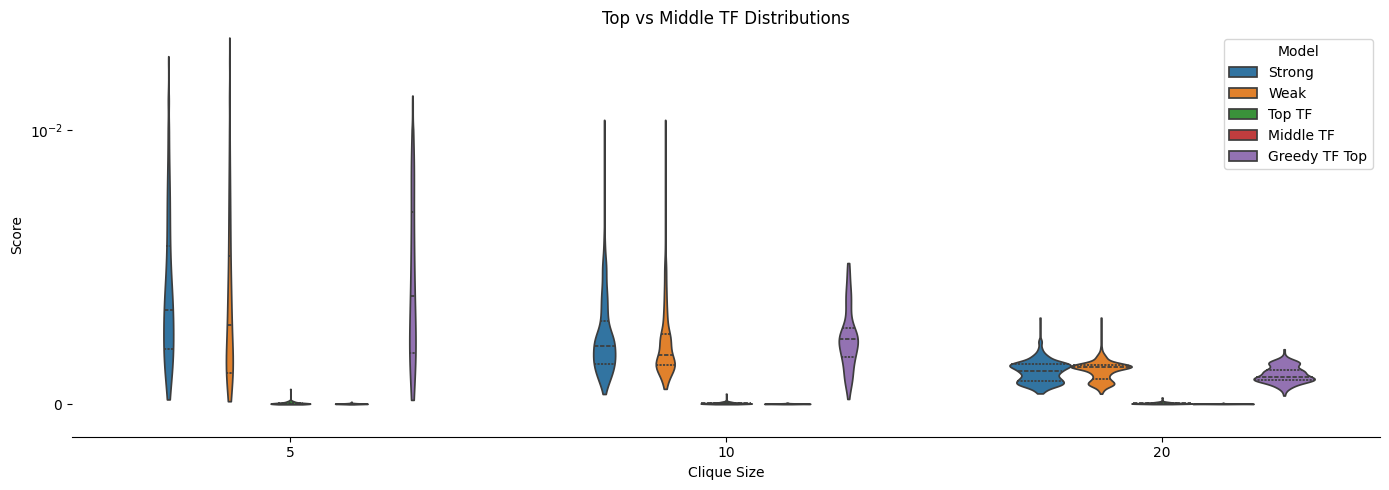

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import functions as f

def get_top_n_tf_clique(clique_size):
    # Load the transcription factor binding sites
    data_dir = './data/transcription_factors'
    tf_files = os.listdir(data_dir)
    interaction_scores = []

    # Contains top 1 bin for each TF
    max_bins = []
    bin_set = set()

    # Return counts of transcription factor binding sites in each 100kb bin
    def process_bed_file(file_path):
        bin_counts = {}

        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('#') or not line.strip():
                    continue
                columns = line.split()
                
                chrom = columns[0]
                start_position = int(columns[1])    
                
                bin_number = f.find_bin(chrom, start_position, bin_map_loc)
                
                if bin_number not in bin_counts:
                    bin_counts[bin_number] = 0
                bin_counts[bin_number] += 1

        return bin_counts



    for filename in os.listdir(data_dir):
        # open file

        try:    
            bin_counts = process_bed_file(os.path.join(data_dir, filename))
        except:
            print(f'Error processing {filename}')
            continue

        # get top 20 bins
        top_bins = sorted(bin_counts, key=bin_counts.get, reverse=True)[:clique_size]

        max_bins.append(top_bins[0])
        bin_set.update(top_bins)

        interaction_strength = f.calculate_avg_interaction_strength(contact_matrix_zero, top_bins)
        interaction_scores.append(interaction_strength)

    return interaction_scores

def get_middle_n_tf_clique(clique_size):
    # Load the transcription factor binding sites
    data_dir = './data/transcription_factors'
    tf_files = os.listdir(data_dir)
    interaction_scores = []

    # Contains middle bins for each TF
    middle_bins = []
    bin_set = set()

    # Return counts of transcription factor binding sites in each 100kb bin
    def process_bed_file(file_path):
        bin_counts = {}

        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('#') or not line.strip():
                    continue
                columns = line.split()
                
                chrom = columns[0]
                start_position = int(columns[1])    
                
                bin_number = f.find_bin(chrom, start_position, bin_map_loc)
                
                if bin_number not in bin_counts:
                    bin_counts[bin_number] = 0
                bin_counts[bin_number] += 1

        return bin_counts

    for filename in os.listdir(data_dir):
        try:    
            bin_counts = process_bed_file(os.path.join(data_dir, filename))
        except:
            print(f'Error processing {filename}')
            continue

 
        sorted_bins = sorted(bin_counts.items(), key=lambda x: x[1], reverse=True)

        total_bins = len(sorted_bins)
        
        start_index = (total_bins - clique_size) // 2
        if start_index < 0:  
            start_index = 0
        
        middle_n_bins = [bin_num for bin_num, _ in sorted_bins[start_index:start_index + clique_size]]

        
        if len(middle_n_bins) < clique_size:
            middle_n_bins = [bin_num for bin_num, _ in sorted_bins]
        
        if middle_n_bins: 
            middle_bins.append(middle_n_bins[0])
            bin_set.update(middle_n_bins)

            interaction_strength = f.calculate_avg_interaction_strength(contact_matrix_zero, middle_n_bins)
            interaction_scores.append(interaction_strength)

    return interaction_scores

def bg_greedy_top_bin_tf(contact_matrix_zero, max_bins, clique_size, bin_map):
    interaction_scores = []
    for bin in tqdm(max_bins):
        top_nodes = f.find_clique_greedy_fast(contact_matrix_zero, clique_size, bin)
        greedy_score  = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
        interaction_scores.append(greedy_score)

    return interaction_scores


# ——— parameters & record collection ———
clique_sizes = [5, 10, 20]
records = []

# 1) load precomputed “strong”/“weak” bg scores from disk
for model_type in ["strong", "weak"]:
    label = "Strong" if model_type == "strong" else "Weak"
    for size in clique_sizes:
        path = (
            f"/Users/ethan/Desktop/chromatin-heart-dev/"
            f"background_models/greedy_scores_{size}_iterations_1000_{model_type}.txt"
        )
        with open(path, "r") as fh:
            scores = [float(line) for line in fh]
        for s in scores:
            records.append({
                "Clique Size": size,
                "Score": s,
                "Model": label
            })

# 2) now call get_top_n_tf_clique for each clique size and append those too
for size in clique_sizes:
    tf_scores = get_top_n_tf_clique(size)
    for s in tf_scores:
        records.append({
            "Clique Size": size,
            "Score": s,
            "Model": "Top TF"
        })

# 3) call get_middle_n_tf_clique for each clique size and append those too
for size in clique_sizes:
    middle_scores = get_middle_n_tf_clique(size)
    for s in middle_scores:
        records.append({
            "Clique Size": size,
            "Score": s,
            "Model": "Middle TF"
        })

# 4) call bg_greedy_top_bin_tf for each clique size and append those too
for size in clique_sizes:
    bg_scores = bg_greedy_top_bin_tf(contact_matrix_zero, max_bins, size, bin_map)
    for s in bg_scores:
        records.append({
            "Clique Size": size,
            "Score": s,
            "Model": "Greedy TF Top"
        })

# build the DataFrame
df = pd.DataFrame.from_records(records)

# ——— plot ———
plt.figure(figsize=(14, 5))
ax = sns.violinplot(
    data=df,
    x="Clique Size",
    y="Score",
    hue="Model",      # will now show Strong, Weak, TF
    dodge=True,
    width=0.7,
    inner="quartile",
    cut=0
)
sns.despine(left=True)
ax.set_yscale('symlog', linthresh=0.01)
ax.set_title("Top vs Middle TF Distributions")
plt.tight_layout()
plt.show()

## More Violin Plot Stuff

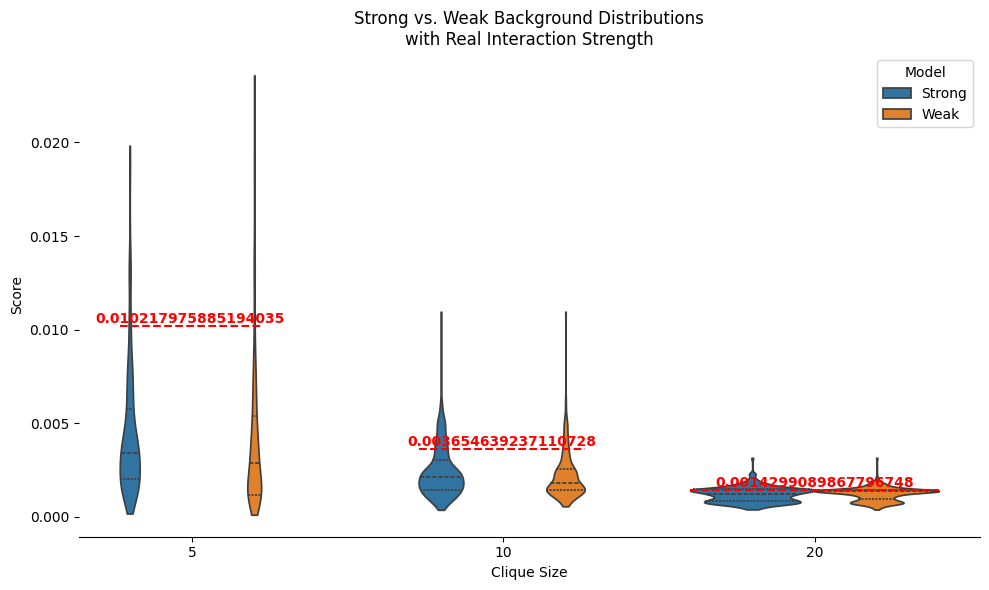

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import PolyCollection


clique_sizes = [5, 10, 20]
models       = ["strong", "weak"]
records      = []
greedy_scores = []

# 2) Compute the real interaction strength once per size,
#    and load each background distribution
for size in clique_sizes:
    # compute on your real contact matrix
    top_nodes = f.find_clique_greedy(contact_matrix_zero, size, TTN_BIN, bin_map)
    gs = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
    greedy_scores.append(gs)

    # load the null distributions
    for m in models:
        path = (
            f"/Users/ethan/Desktop/chromatin-heart-dev/"
            f"background_models/greedy_scores_{size}_iterations_1000_{m}.txt"
        )
        with open(path, "r") as bg:
            bg_scores = [float(line) for line in bg]
        for s in bg_scores:
            records.append({
                "Clique Size": size,
                "Score":       s,
                "Model":       m.capitalize()
            })

# 3) Build a DataFrame
df = pd.DataFrame.from_records(records)

# 4) Draw the side‐by‐side violins
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
    data=df,
    x="Clique Size",
    y="Score",
    hue="Model",
    dodge=True,
    inner="quartile",
    cut=0,
    ax=ax
)

# 5) Overlay a horizontal line at each greedy_score
bodies   = [c for c in ax.collections if isinstance(c, PolyCollection)]
n_models = len(models)  # 2 in this case

for j, size in enumerate(clique_sizes):
    # the two violins for this size occupy positions j*2 and j*2+1 in `bodies`
    group = bodies[j*n_models:(j+1)*n_models]

    # collect all x‐coords across both violins
    xs = []
    for body in group:
        verts = body.get_paths()[0].vertices
        xs.extend(verts[:,0])
    x_min, x_max = min(xs), max(xs)

    y = greedy_scores[j]
    # draw the line
    ax.hlines(y, x_min, x_max, colors="red", linestyles="--")
    # annotate the exact value
    ax.text(
        (x_min + x_max)/2, y,
        y,
        ha="center", va="bottom",
        color="red", fontweight="bold"
    )

sns.despine(left=True)
plt.title("Strong vs. Weak Background Distributions\nwith Real Interaction Strength")
plt.tight_layout()
plt.show()

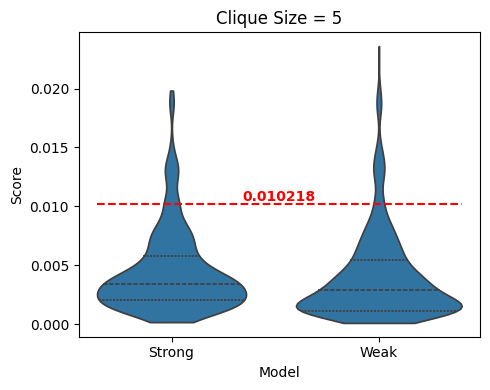

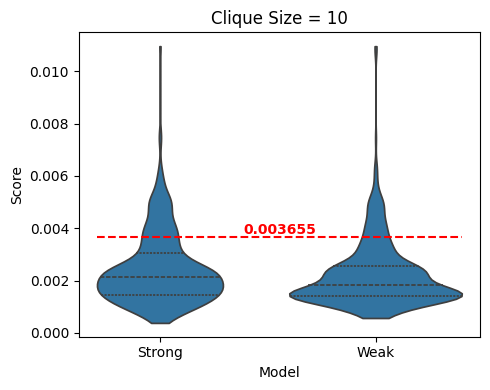

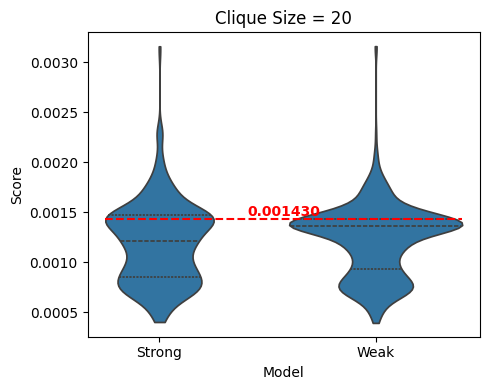

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import PolyCollection

clique_sizes = [5, 10, 20]
models = ["strong", "weak"]

greedy_scores = [
    f.calculate_avg_interaction_strength(
        contact_matrix_zero,
        f.find_clique_greedy(contact_matrix_zero, s, TTN_BIN, bin_map)
    )
    for s in clique_sizes
]

records = []
for s in clique_sizes:
    for m in models:
        path = f"/Users/ethan/Desktop/chromatin-heart-dev/background_models/greedy_scores_{s}_iterations_1000_{m}.txt"
        scores = [float(x) for x in open(path)]
        records += [{"Clique Size": s, "Score": v, "Model": m.capitalize()} for v in scores]

df = pd.DataFrame(records)

for i, s in enumerate(clique_sizes):
    fig, ax = plt.subplots(figsize=(5, 4))
    sub = df[df["Clique Size"] == s]
    sns.violinplot(data=sub, x="Model", y="Score", inner="quartile", cut=0, ax=ax)
    bodies = [c for c in ax.collections if isinstance(c, PolyCollection)]
    xs = [v for body in bodies for v in body.get_paths()[0].vertices[:, 0]]
    y = greedy_scores[i]
    ax.hlines(y, min(xs), max(xs), color="red", linestyle="--")
    ax.text((min(xs) + max(xs)) / 2, y, f"{y:.6f}", ha="center", va="bottom", color="red", fontweight="bold")
    ax.set_title(f"Clique Size = {s}")
    plt.tight_layout()
    plt.show()

## Stat Testing

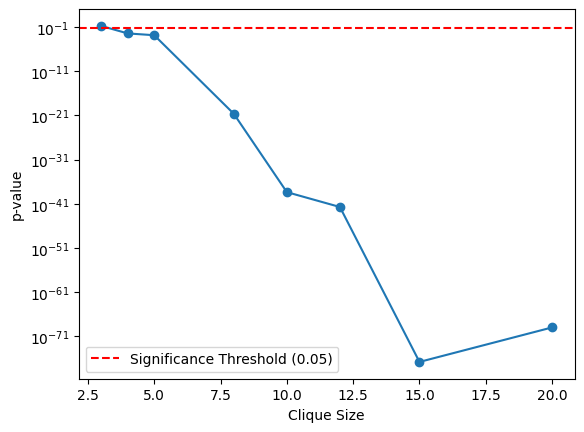

In [88]:
clique_sizes = [3, 4, 5, 8, 10, 12, 15, 20]
p_values = []

for i in clique_sizes:
    with open(f'/Users/ethan/Desktop/chromatin-heart-dev/background_models/greedy_scores_{i}_iterations_1000.txt', 'r') as bg:
        bg_scores = bg.read().splitlines()
        bg_scores = [float(score) for score in bg_scores]

        top_nodes = f.find_clique_greedy(contact_matrix_zero, i, TTN_BIN, bin_map)
        greedy_score = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)

        p_value = t_test(greedy_score, bg_scores)
        p_values.append(p_value)


plt.plot(clique_sizes, p_values, marker='o')
plt.xlabel('Clique Size')
plt.ylabel('p-value')
plt.yscale('log')  # Useful if values vary widely
plt.axhline(0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.legend()
plt.show()

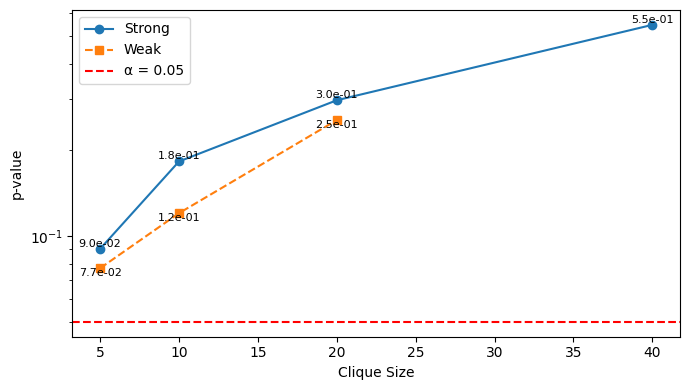

In [61]:
import matplotlib.pyplot as plt

sizes_strong = [5, 10, 20, 40]
sizes_weak   = [5, 10, 20]

# Compute strong p‑values
p_strong = []
for size in sizes_strong:
    with open(
        f'/Users/ethan/Desktop/chromatin-heart-dev/'
        f'background_models/greedy_scores_{size}_iterations_1000_strong.txt',
        'r'
    ) as strong_bg_file:
        bg_scores_strong = [float(line) for line in strong_bg_file]

    nodes = f.find_clique_greedy(contact_matrix_zero, size, TTN_BIN, bin_map)
    score = f.calculate_avg_interaction_strength(contact_matrix_zero, nodes)
    p_strong.append(empirical_p_value(score, bg_scores_strong))

# Compute weak p‑values
p_weak = []
for size in sizes_weak:
    with open(
        f'/Users/ethan/Desktop/chromatin-heart-dev/'
        f'background_models/greedy_scores_{size}_iterations_1000_weak.txt',
        'r'
    ) as weak_bg_file:
        bg_scores_weak = [float(line) for line in weak_bg_file]

    # reuse the same nodes/score or recompute if you prefer:
    nodes = f.find_clique_greedy(contact_matrix_zero, size, TTN_BIN, bin_map)
    score = f.calculate_avg_interaction_strength(contact_matrix_zero, nodes)
    p_weak.append(empirical_p_value(score, bg_scores_weak))

# Plot both series
plt.figure(figsize=(7,4))
plt.plot(sizes_strong, p_strong, marker='o', linestyle='-', label='Strong')
plt.plot(sizes_weak,   p_weak,   marker='s', linestyle='--', label='Weak')

plt.xlabel('Clique Size')
plt.ylabel('p-value')
plt.yscale('log')
plt.axhline(0.05, color='r', linestyle='--', label='α = 0.05')

# Annotate points
for x, y in zip(sizes_strong, p_strong):
    plt.text(x, y, f"{y:.1e}", ha='center', va='bottom', fontsize=8)
for x, y in zip(sizes_weak, p_weak):
    plt.text(x, y, f"{y:.1e}", ha='center', va='top',    fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()

In [573]:
def get_stats_from_bg_model(type, clique_size, iterations):
    file_suffix = 'iterations' if type == 'greedy' else 'molecules'
    file_path = f'/Users/ethan/Desktop/chromatin-heart-dev/background_models/{type}_scores_{clique_size}_{file_suffix}_{iterations}.txt'
    
    with open(file_path, 'r') as bg:
        bg_scores = [float(score) for score in bg.read().splitlines()]
    
    top_nodes = f.find_clique_greedy(contact_matrix_zero, clique_size, TTN_BIN, bin_map)
    greedy_score = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)

    mean_bg = np.mean(bg_scores)
    var_bg = np.var(bg_scores)
    std_bg = np.std(bg_scores)

    p_value = mann_whitney_u_test(greedy_score, bg_scores)
    percent_higher = np.mean(np.array(bg_scores) > greedy_score) * 100

    print(f'TTN Clique Score: {greedy_score:.4f}')
    print(f'Background Scores Mean: {mean_bg:.4f}')
    print(f'Background Scores Variance: {var_bg:.4f}')
    print(f'Background Scores Std Dev: {std_bg:.4f}')
    print(f'Percentage of Background Scores Higher Than TTN: {percent_higher:.2f}%')
    print(f'p-value: {p_value:.3e}')

In [574]:
get_stats_from_bg_model('greedy', 5, 1000)

TTN Clique Score: 0.0102
Background Scores Mean: 0.0045
Background Scores Variance: 0.0000
Background Scores Std Dev: 0.0038
Percentage of Background Scores Higher Than TTN: 9.10%
p-value: 1.229e-251


In [575]:
get_stats_from_bg_model('greedy', 8, 1000)

TTN Clique Score: 0.0051
Background Scores Mean: 0.0030
Background Scores Variance: 0.0000
Background Scores Std Dev: 0.0019
Percentage of Background Scores Higher Than TTN: 15.50%
p-value: 9.693e-180


In [572]:
import numpy as np
from scipy.stats import norm

# Given values
ttn_score = 0.0051
mean_bg = 0.0030
std_bg = 0.0019

# Z-score calculation
z_score = (ttn_score - mean_bg) / std_bg

# P-value calculation from Z-score (one-tailed test)
p_value_from_z = 1 - norm.cdf(z_score)

print(f'Z-score: {z_score:.2f}')
print(f'P-value from Z-score: {p_value_from_z:.3e}')

Z-score: 1.11
P-value from Z-score: 1.345e-01


## Alpha selection

To investigate the most optimal alpha for building a clique around TTN, a comparison between strong/weak distributions will be made, looking at how the fold change between the median and mann whitney p value.

In [10]:
from scipy.stats import mannwhitneyu

In [27]:
def random_walk_fast(contact_matrix, start_node, n,
                     neighbors, cdfs,
                     num_molecules=100, alpha=0.1):
    """
    A much faster random‐walk using prebuilt neighbor/CDF lists.
    """
    N = contact_matrix.shape[0]
    visit_count = np.zeros(N, dtype=int)

    for _ in tqdm(range(num_molecules)):
        cur = start_node
        while True:
            visit_count[cur] += 1
            if np.random.rand() < alpha or neighbors[cur].size == 0:
                break
            r = np.random.rand()
            # find next index in CDF
            j = np.searchsorted(cdfs[cur], r, side='right')
            cur = neighbors[cur][j]

    # top-n visited
    return np.argsort(visit_count)[-n:][::-1]

In [45]:
clique = random_walk_fast(
    contact_matrix_zero, start_node=4275, n=5,
    neighbors=neighbors, cdfs=cdfs,
    num_molecules=5000000, alpha=0.1
)
print(clique)

100%|██████████| 5000000/5000000 [04:44<00:00, 17568.60it/s]

[ 4275 30478 28240 28248 24025]


Random walks: 100%|██████████| 1000/1000 [00:03<00:00, 293.82iter/s]


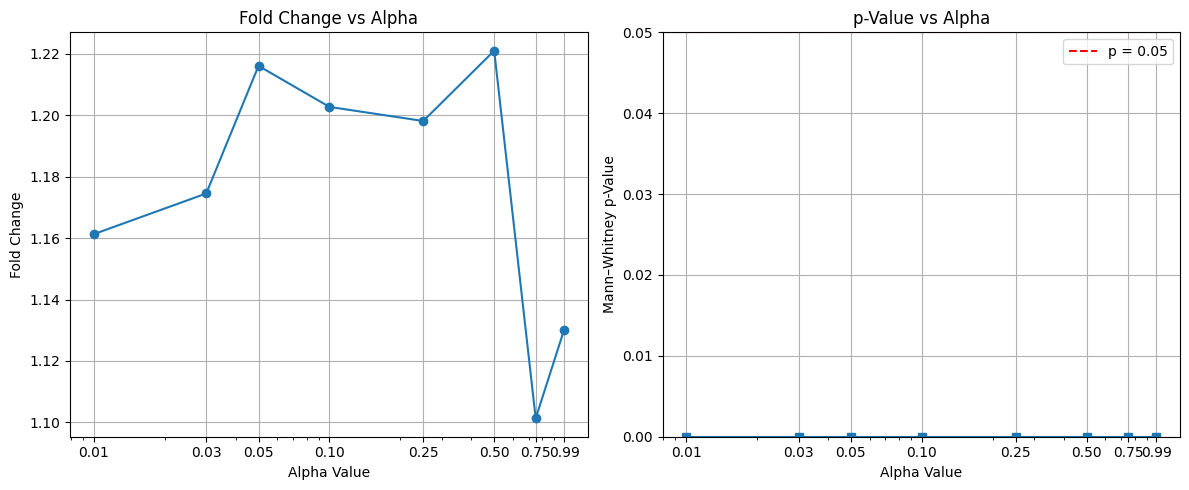

In [71]:
import functions as f
from matplotlib.ticker import ScalarFormatter

clique_size     = 10
num_iterations  = 1000
alphas          = [0.01, 0.03, 0.05, 0.1, 0.25, 0.5, 0.75, 0.99]

fold_changes = []
p_values     = []

for alpha in alphas:
    bg_strong = f.create_background_model_rw(
        contact_matrix_zero,
        clique_size,
        bins=gene_bins,
        label='strong',
        num_molecules=1000,
        neighbors=neighbors,
        cdfs=cdfs,
        num_iterations=num_iterations,
        alpha=alpha,
        plot=False
    )
    bg_weak = f.create_background_model_rw(
        contact_matrix_zero,
        clique_size,
        bins=non_gene_bins,
        label='weak',
        num_molecules=1000,
        neighbors=neighbors,
        cdfs=cdfs,
        num_iterations=num_iterations,
        alpha=alpha,
        plot=False
    )

    fold_change = np.median(bg_strong) / np.median(bg_weak)
    _, p_value  = mannwhitneyu(bg_strong, bg_weak, alternative='greater')

    fold_changes.append(fold_change)
    p_values.append(p_value)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# fold-Change vs alpha
ax1.plot(alphas, fold_changes, marker='o')
ax1.set_xscale('log')
ax1.set_xticks(alphas)
ax1.get_xaxis().set_major_formatter(ScalarFormatter())
ax1.set_xlabel('Alpha Value')
ax1.set_ylabel('Fold Change')
ax1.set_title('Fold Change vs Alpha')
ax1.grid(True)

# p-value vs alpha with p=0.05 line
ax2.plot(alphas, p_values, marker='s')
ax2.axhline(0.05, linestyle='--', color='red', label='p = 0.05')
ax2.set_xscale('log')
ax2.set_xticks(alphas)
ax2.get_xaxis().set_major_formatter(ScalarFormatter())
ax2.set_xlabel('Alpha Value')
ax2.set_ylabel('Mann–Whitney p-Value')
ax2.set_title('p-Value vs Alpha')


max_p = max(p_values)
top = max(max_p * 1.1, 0.05)
ax2.set_ylim(0, top)

ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Molecules vs Time

100%|██████████| 250000/250000 [14:27<00:00, 288.27it/s] 


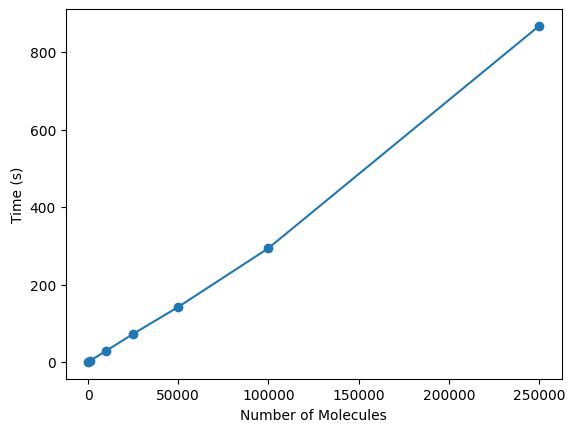

In [10]:
import time
# plot molecules to time
molecules = [100,1000,10000,25000,50000, 100000, 250000]
time_values = []

for m in molecules:
    start = time.time()
    top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=m, alpha=0.05, verbose=True)
    end = time.time()
    time_values.append(end-start)

plt.plot(molecules, time_values, marker='o')
plt.xlabel('Number of Molecules')
plt.ylabel('Time (s)')
plt.show()


## Alpha vs Time

100%|██████████| 1000/1000 [00:00<00:00, 2950.89it/s]


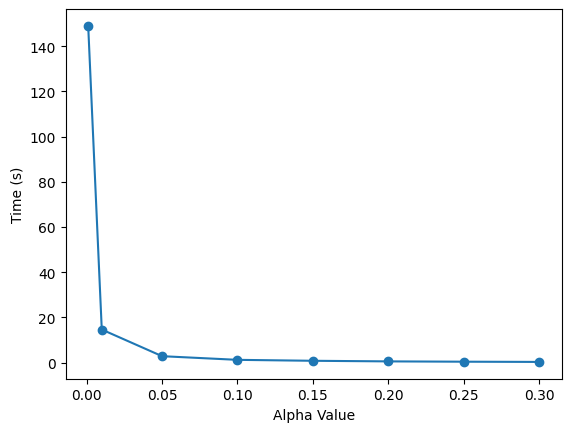

In [12]:
# plot alpha values to time using clique size 5
alphas = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
time_values = []

for a in alphas:
    start = time.time()
    top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=1000, alpha=a, verbose=True)
    end = time.time()
    time_values.append(end-start)

plt.plot(alphas, time_values, marker='o')
plt.xlabel('Alpha Value')
plt.ylabel('Time (s)')
plt.show()



## Alpha vs p value, (for now can use clique size 5)

In [8]:
top_nodes

array([ 4277, 30386, 28366, 30438,  9294])

In [6]:
top_nodes

array([ 4277, 30364,  6840,  5342, 28072])

Processing: 100%|██████████| 1000/1000 [00:02<00:00, 498.74iteration/s]


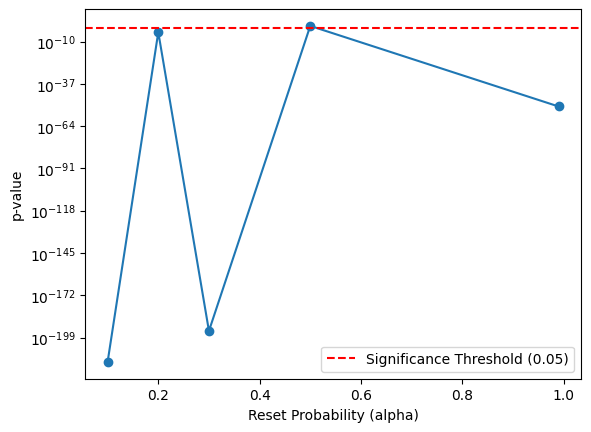

In [50]:
from tqdm import tqdm
import matplotlib.pyplot as plt

alphas = [0.1, 0.2, 0.3, 0.5, 0.99]
p_values = []

for a in alphas:
    top_nodes = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=1000, alpha=a, verbose=True)
    rw_score = f.calculate_avg_interaction_strength(contact_matrix_zero, top_nodes)
    bg_model_rw = f.create_background_model_rw_strong(contact_matrix_zero, 5, gene_bins=gene_bins, num_molecules=1000, num_iterations=1000, alpha=a)

    p_value = mann_whitney_u_test(rw_score, bg_model_rw)
    p_values.append(p_value)

plt.plot(alphas, p_values, marker='o')
plt.xlabel('Reset Probability (alpha)')
plt.ylabel('p-value')
plt.yscale('log')  # Log scale if values vary widely
plt.axhline(0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.legend()
plt.show()

## Bed Narrow Peak

In [78]:
import functions as f
# LOAD BIN MAP
bin_map_loc = f.load_bin_map_loc('/Users/ethan/Desktop/chromatin-heart-dev/data/bin_map_human_100000.bed')

In [79]:
f.find_bin('chr2', 61443502, bin_map_loc)

3104

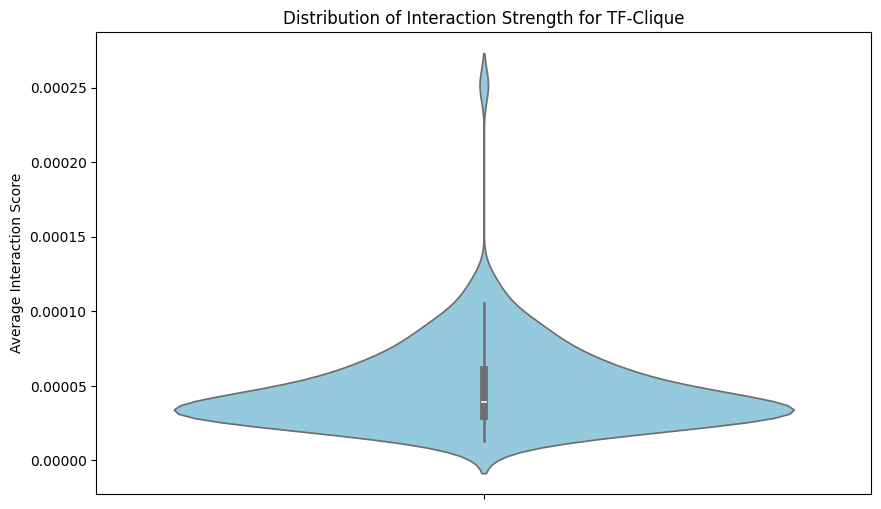

In [80]:
# Open data/transcription_factors, contains a directory of .bed files containing transcription factor binding sites

import os
import pandas as pd
import seaborn as sns

# Load the transcription factor binding sites
data_dir = './data/transcription_factors'
tf_files = os.listdir(data_dir)

# Return counts of transcription factor binding sites in each 100kb bin
def process_bed_file(file_path):
    bin_counts = {}

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#') or not line.strip():
                continue
            columns = line.split()
            
            chrom = columns[0]
            start_position = int(columns[1])    
            
            bin_number = f.find_bin(chrom, start_position, bin_map_loc)
            
            if bin_number not in bin_counts:
                bin_counts[bin_number] = 0
            bin_counts[bin_number] += 1

    return bin_counts

interaction_scores = []

# Contains top 1 bin for each TF
max_bins = []
bin_set = set()

for filename in os.listdir(data_dir):
    # open file

    try:    
        bin_counts = process_bed_file(os.path.join(data_dir, filename))
    except:
        print(f'Error processing {filename}')
        continue

    # get top 20 bins
    top_bins = sorted(bin_counts, key=bin_counts.get, reverse=True)[:20]

    max_bins.append(top_bins[0])
    bin_set.update(top_bins)

    interaction_strength = f.calculate_avg_interaction_strength(contact_matrix_zero, top_bins)
    interaction_scores.append(interaction_strength)

    # get span of chromosmes of the top bins
    chrom_span = f.get_chromosome_span(top_bins, bin_map)



# Plot the distribution as a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(y=interaction_scores, inner='box', color='skyblue')
plt.ylabel('Average Interaction Score')
plt.title('Distribution of Interaction Strength for TF-Clique')
plt.show()
    


In [19]:
max(interaction_scores)

np.float64(0.00025158912799886306)

In [94]:
max_bins

[10572,
 4799,
 19237,
 28038,
 28038,
 1552,
 10879,
 18745,
 1925,
 27040,
 10874,
 19237,
 1610,
 10876,
 22144,
 4682,
 26682,
 27675,
 12378,
 18745,
 26616,
 25319,
 22160,
 24995,
 30077,
 10616,
 22144,
 21768,
 5897,
 25196,
 27862,
 10876,
 10875,
 19559,
 25319,
 25319,
 25695,
 24995,
 1606,
 19237,
 10879,
 30077,
 26973,
 22144,
 18745,
 30077,
 27625,
 1606,
 18745,
 25688,
 282,
 26378,
 1925,
 26378,
 18745,
 10892,
 10892,
 22415,
 26678,
 10617,
 10892,
 1606,
 26571,
 18745,
 1165,
 18745,
 25695,
 18745,
 14921,
 18745,
 9991,
 22125,
 24934,
 26332,
 22144,
 10875,
 27136,
 28038,
 22144,
 24995,
 12378,
 19237,
 10610,
 18745,
 10874,
 18749,
 30077,
 1606,
 27598,
 10876,
 9991,
 19237,
 10892,
 22144,
 18745,
 20366,
 1925,
 25319,
 1606,
 1925,
 2487,
 2217,
 10892,
 25319,
 10876,
 1606,
 10892,
 27674,
 18765,
 9358,
 24995,
 16114,
 26563,
 25688,
 26378,
 26563,
 10617,
 18745,
 26616,
 25512,
 18745,
 10892,
 26571,
 19237,
 10940,
 26563,
 24995,
 22144,

100%|██████████| 138/138 [00:53<00:00,  2.56it/s]


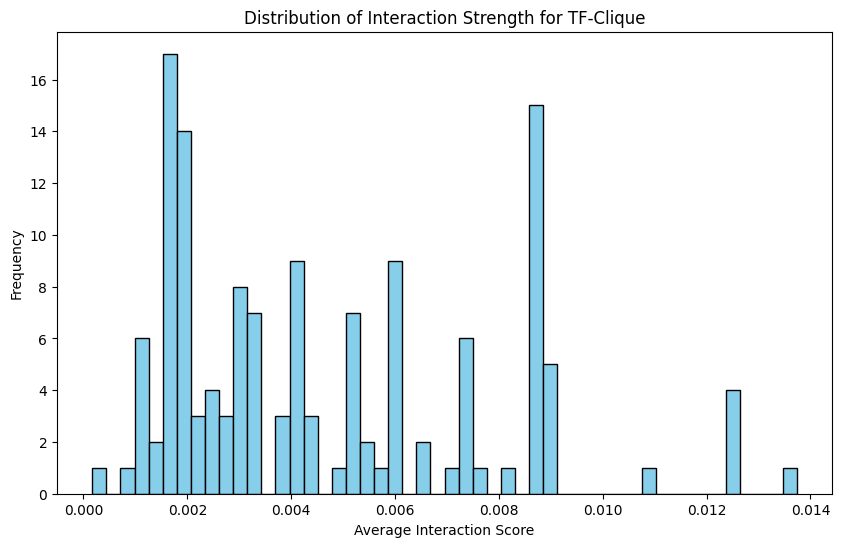

In [81]:
interaction_scores = []

for i in tqdm(range(len(max_bins))):
    clique = f.find_clique_greedy(contact_matrix_zero, 5, max_bins[i], bin_map)
    score = f.calculate_avg_interaction_strength(contact_matrix_zero, clique)
    interaction_scores.append(score)

# Plot the distribution of interaction scores
plt.figure(figsize=(10, 6))
plt.hist(interaction_scores, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Average Interaction Score')
plt.ylabel('Frequency')
plt.title(f'Distribution of Interaction Strength for TF-Clique')
plt.show()



    

100%|██████████| 138/138 [07:32<00:00,  3.28s/it]


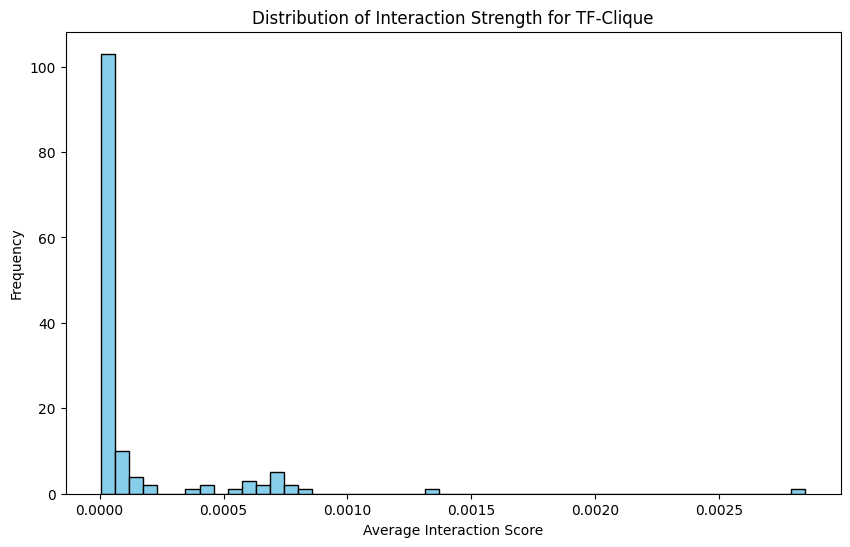

In [83]:
interaction_scores = []

for i in tqdm(range(len(max_bins))):
    clique = f.random_walk(contact_matrix_zero, max_bins[i], 5, num_molecules=1000, alpha=0.05, verbose=False)
    score = f.calculate_avg_interaction_strength(contact_matrix_zero, clique)
    interaction_scores.append(score)

# Plot the distribution of interaction scores
plt.figure(figsize=(10, 6))
plt.hist(interaction_scores, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Average Interaction Score')
plt.ylabel('Frequency')
plt.title(f'Distribution of Interaction Strength for TF-Clique')
plt.show()



    

In [86]:
ttn_clique = f.random_walk(contact_matrix_zero, TTN_BIN, 5, num_molecules=1000, alpha=0.05, verbose=False)
score_rw = f.calculate_avg_interaction_strength(contact_matrix_zero, ttn_clique)

t_test(score_rw, interaction_scores)

np.float64(7.71623512307287e-05)

## Genes from TTN Clique

In [10]:
import functions as f

In [ ]:
# 4275, 4276, 4277, 4278

In [11]:
top_40_clique = f.find_clique_greedy(contact_matrix_zero, 40, TTN_BIN, bin_map)

In [ ]:
fdasdsas = f.find_clique_greedy(contact_matrix_zero, 40, TTN_BIN, bin_map)

In [12]:
top_40_clique

[4275,
 30478,
 25137,
 30357,
 29661,
 30369,
 29677,
 29699,
 29533,
 5505,
 29108,
 30387,
 29648,
 29755,
 30174,
 27440,
 20466,
 29592,
 29631,
 12903,
 29739,
 2087,
 30185,
 29463,
 13823,
 28903,
 8961,
 28017,
 28812,
 16609,
 4335,
 17300,
 15492,
 7582,
 19516,
 15063,
 5704,
 8336,
 20178,
 15542]

In [35]:
from tqdm import tqdm

TTN_GENES = set()
for bin in tqdm(top_40_clique):
    genes = f.find_gene_from_bin(bin, '/Users/ethan/Desktop/chromatin-heart-dev/data/bin_map_human_100000.bed', '/Users/ethan/Desktop/chromatin-heart-dev/data/gencode.v38.annotation.gtf')
    TTN_GENES.update(genes)

100%|██████████| 40/40 [04:59<00:00,  7.50s/it]


In [43]:
top_40_clique_rw = f.random_walk(contact_matrix_zero, TTN_BIN, 40, num_molecules=1000, alpha=0.05, verbose=True)

100%|██████████| 1000/1000 [00:09<00:00, 106.25it/s]


In [44]:
top_40_clique_rw

array([ 4275, 21173, 11137,  7488, 24146,   126, 26531, 16746, 16350,
       24685, 23414, 19906, 22635, 22444,  8600, 28445, 28604, 17444,
       26614, 12589,  6534, 20291, 24950,  1566, 17973, 28249,  3773,
       19512, 27395,  7655,  9916,  7652, 13360,  8777, 27211, 12491,
       15434,  4754, 21844, 13318])

In [45]:
TTN_GENES_RW = set()    

for bin in tqdm(top_40_clique_rw):
    genes = f.find_gene_from_bin(bin, '/Users/ethan/Desktop/chromatin-heart-dev/data/bin_map_human_100000.bed', '/Users/ethan/Desktop/chromatin-heart-dev/data/gencode.v38.annotation.gtf')
    TTN_GENES_RW.update(genes)

100%|██████████| 40/40 [05:13<00:00,  7.84s/it]


In [ ]:
len(TTN_GENES)

1814

In [33]:
# write list to file

with open('/Users/ethan/Desktop/chromatin-heart-dev/TTN_genes.txt', 'w') as tg:
    for item in TTN_GENES:
        tg.write("%s\n" % item)




In [10]:
import functions as f

from time import time

start = time()


f.random_walk_fast(
    contact_matrix_zero, TTN_BIN, 5,
    neighbors=neighbors, cdfs=cdfs,
    num_molecules=10000, alpha=0.05
)
end = time()

print(f"Time taken: {end - start} seconds")

Time taken: 36.014204025268555 seconds
